In [ ]:
!pip install torch
!pip install torcheval
!pip install transformers
!pip install numpy
!pip install pandas
!pip install sentencepiece
!pip install pytorch-lightning
!pip install seaborn as sns
!pip install matplotlib.pyplot as plt
!pip install accelerate -U


ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd

df = pd.read_table('home/train.txt', header=None, names=['Index','Text','Emotion','Intensity'])
df


FileNotFoundError: ignored

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3612 entries, 0 to 3611
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      3612 non-null   object 
 1   Text       3612 non-null   object 
 2   Emotion    3612 non-null   object 
 3   Intensity  3612 non-null   float64
dtypes: float64(1), object(3)
memory usage: 113.0+ KB


<Axes: xlabel='Emotion', ylabel='Intensity'>

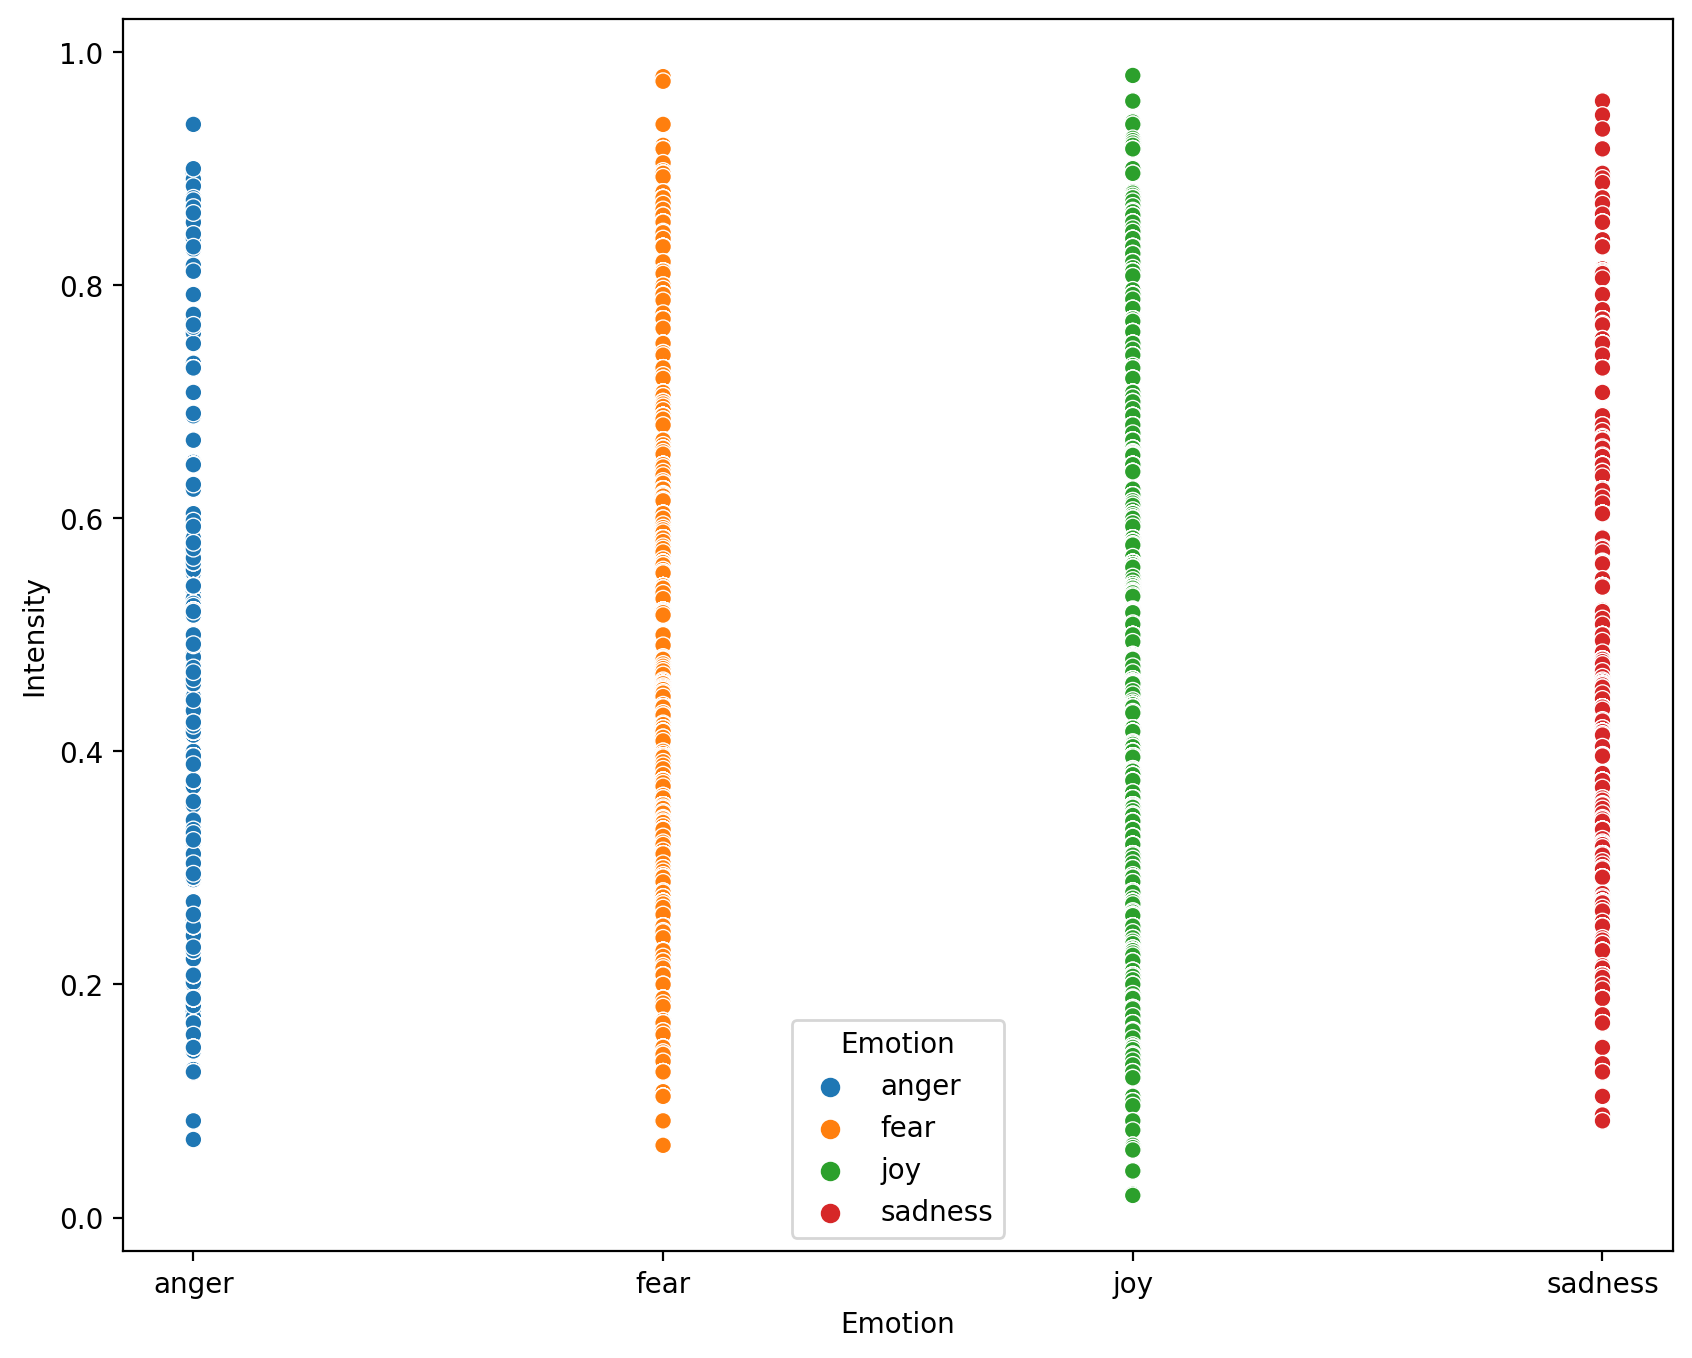

In [ ]:
plt.figure(figsize=(10,8),dpi=200)
sns.scatterplot(data=df, x='Emotion',y='Intensity',hue='Emotion')

<Figure size 2000x1600 with 0 Axes>

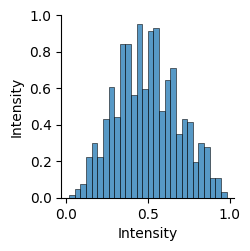

In [ ]:
plt.figure(figsize=(10,8),dpi=200)
sns.pairplot(data=df)

<Figure size 2000x1600 with 0 Axes>

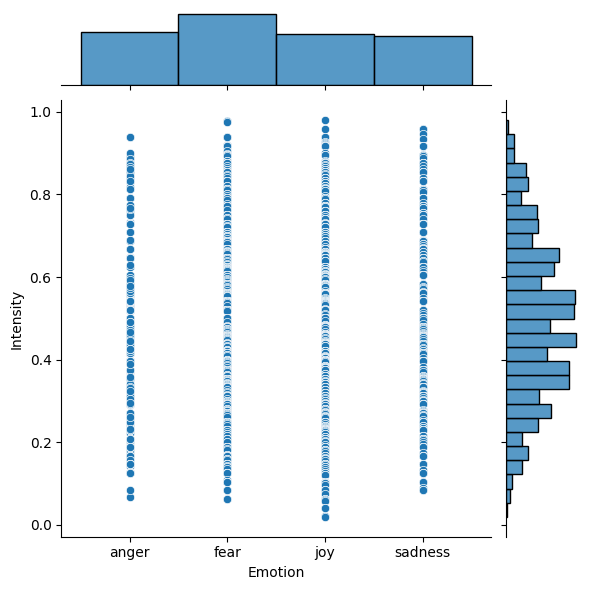

In [ ]:
plt.figure(figsize=(10,8),dpi=200)
sns.jointplot(data=df,x='Emotion',y='Intensity')

<Axes: xlabel='Intensity', ylabel='Count'>

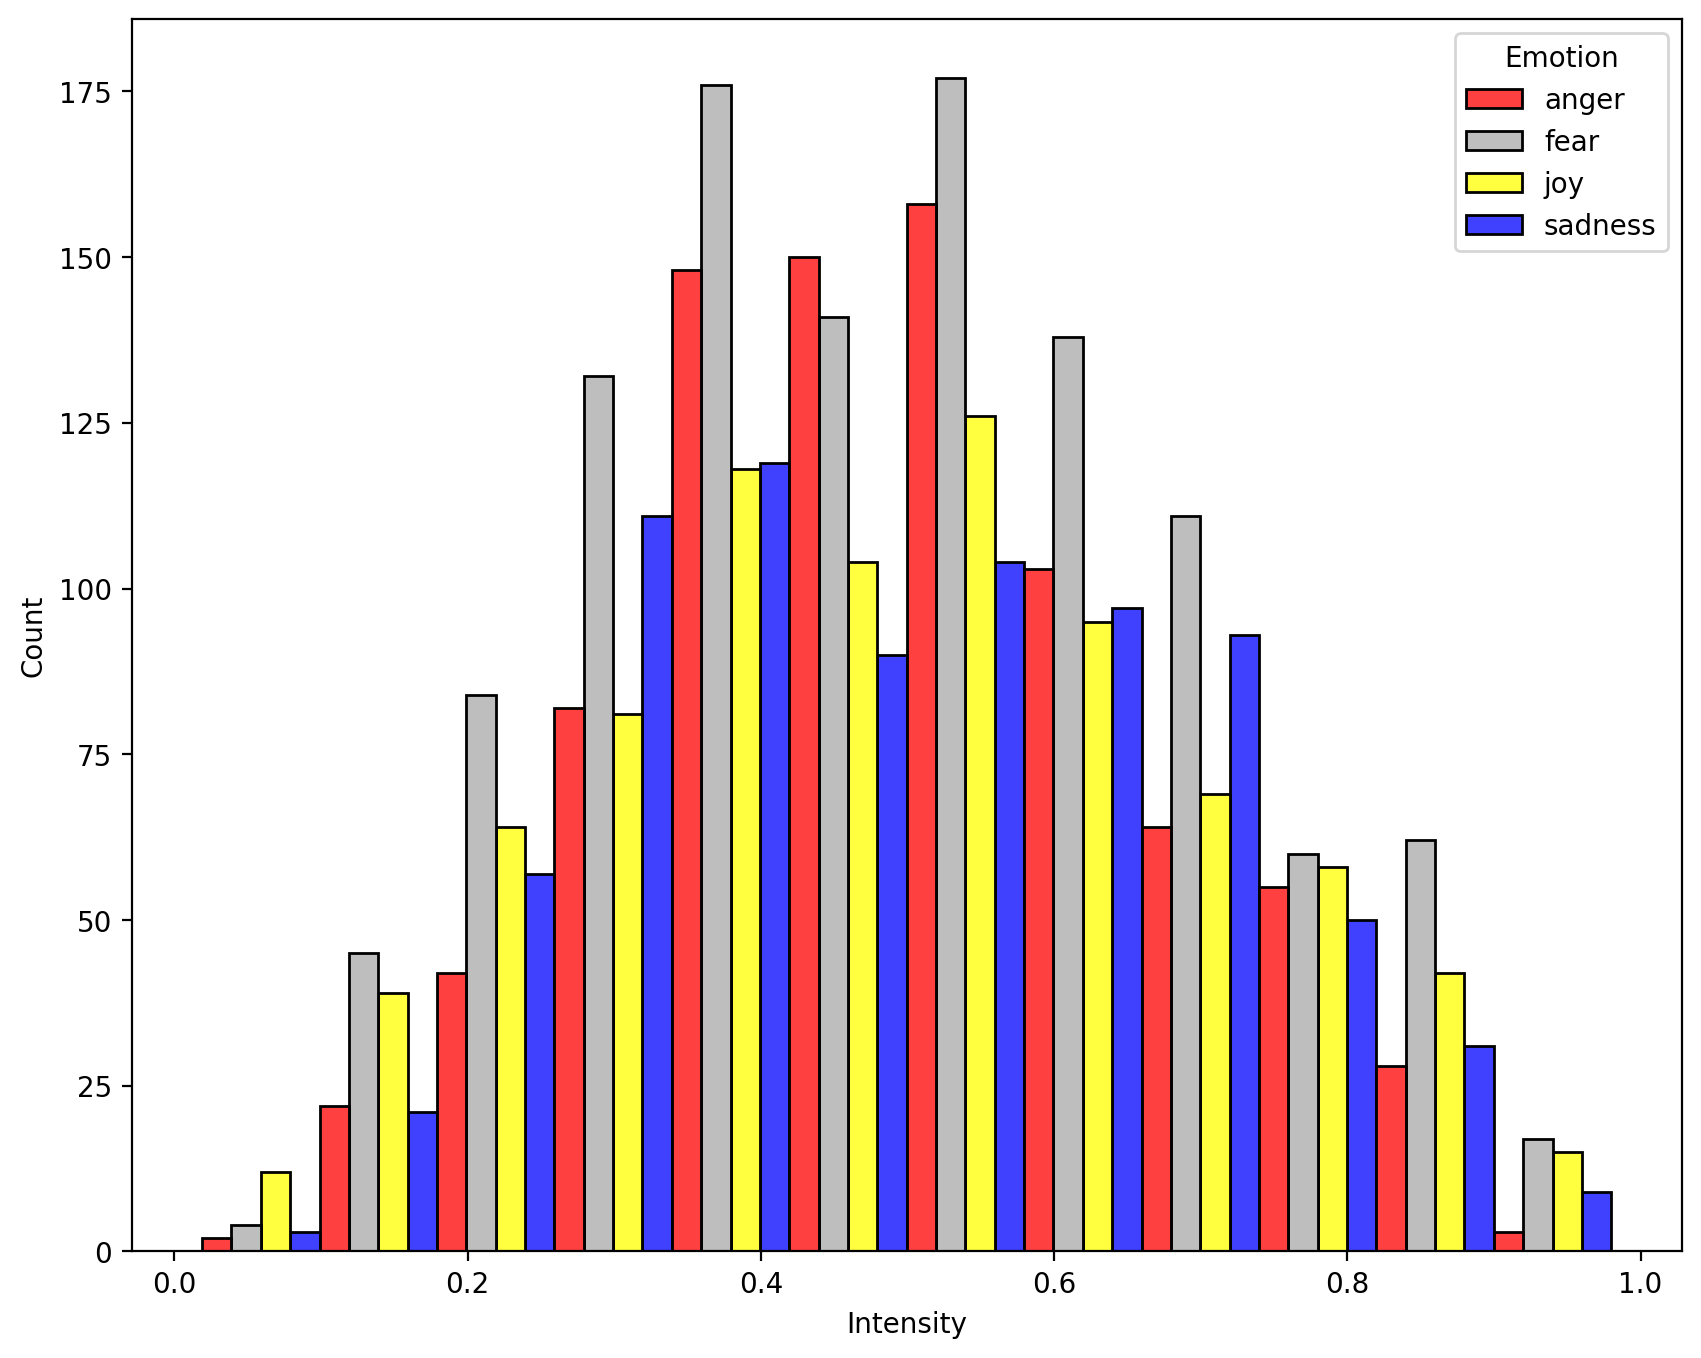

In [ ]:
plt.figure(figsize=(10,8),dpi=200)
sns.histplot(data=df,x='Intensity',hue='Emotion',element='bars',multiple='dodge',stat='count',bins=12,legend=True,palette=['red','#a9a9a9',"yellow","blue"])


In [ ]:
import pandas as pd

results_df = pd.DataFrame({'Metric':['Classifcation Loss','Regression Loss','Training F1','Test F1', 'Validation F1','Training R2', 'Test R2', 'Validation R2','Max Epoch','Optimzizer','Learning Rate','Patience','Batch Size']})
results_df

Metric
0   Classifcation Loss
1      Regression Loss
2          Training F1
3              Test F1
4        Validation F1
5          Training R2
6              Test R2
7        Validation R2
8            Max Epoch
9           Optimzizer
10       Learning Rate
11            Patience
12          Batch Size

# BERT MultiModal with Classification + Regression


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW,RobertaTokenizer,RobertaForSequenceClassification
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score,f1_score,confusion_matrix
from torch.optim import RMSprop,SGD,Adagrad
import torch.nn as nn
from torcheval.metrics import R2Score




# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
classification_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

class RegressionHead(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionHead, self).__init__()
        # self.fc1 = torch.nn.Linear(input_size, hidden_size)
        # self.fc2 = torch.nn.Linear(hidden_size, 1)
        # self.dropout = torch.nn.Dropout(0.2)  # Dropout for regularization
        self.regression = torch.nn.Linear(hidden_size,1)
        # self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        # x = torch.nn.functional.relu(self.fc1(x))
        # x = self.dropout(x)  # Apply Dropout
        # x = self.fc2(x)
        x = self.regression(x)
        # x = self.relu(x)
        x= self.sigmoid(x)

        return x

# Define the Multi-Task Emotion Model
class MultiTaskEmotionModel(torch.nn.Module):
    def __init__(self, bert_model, num_classes,input_size,hidden_size):
        super(MultiTaskEmotionModel, self).__init__()
        self.bert = bert_model
        self.classification_head = torch.nn.Linear(self.bert.config.hidden_size, num_classes)
        # self.regression_head = torch.nn.Linear(self.bert.config.hidden_size, 1)
        # self.regression_head = RegressionHead(input_size, hidden_size)
        self.regression_head = RegressionHead(input_size, self.bert.config.hidden_size)



    def forward(self, input_ids, attention_mask=None):
        # print(f"input_ids: {input_ids}")
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,output_hidden_states=True)

        pooled_output = outputs.hidden_states[-1][:, 0, :]

        # For classification task
        classification_logits = self.classification_head(pooled_output)


        # For regression task
        regression_output = self.regression_head(pooled_output)


        return classification_logits, regression_output

# Function to load and preprocess the data
def load_data(file_path, tokenizer):
    texts = []
    labels_classification = []
    labels_regression = []

    with open(file_path, encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 4:
              text, emotion, intensity =  parts[1], parts[2], float(parts[3])
              texts.append(text)
              labels_classification.append(emotion)
              labels_regression.append(intensity)


    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Use label encoding for emotion labels
    emotion_label_encoder = LabelEncoder()
    labels_classification_encoded = emotion_label_encoder.fit_transform(labels_classification)

    labels_classification = torch.tensor(labels_classification_encoded)
    labels_regression = torch.tensor(labels_regression,dtype=torch.float)


    return TensorDataset(inputs.input_ids, inputs.attention_mask, labels_classification, labels_regression)

# # Load the data
train_dataset = load_data('home/train.txt', tokenizer)
valid_dataset = load_data('home/dev.txt', tokenizer)
test_dataset = load_data('home/test.txt', tokenizer)

# Create DataLoader objects
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=True)

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the multi-task model
NUM_CLASSES = 4  # Number of emotion categories (anger, fear, joy, sadness)
multi_task_model = MultiTaskEmotionModel(classification_model, num_classes=NUM_CLASSES,input_size=768,hidden_size=32)
multi_task_model.to(device)

LEARNING_RATE = 2.3e-5
OPTIMIZER = 'AdamW'

# Set up the optimizer and loss functions
optimizer = torch.optim.AdamW(multi_task_model.parameters(), lr=LEARNING_RATE)
# optimizer = RMSprop(multi_task_model.parameters(), lr=LEARNING_RATE)
# optimizer = SGD(multi_task_model.parameters(), lr=LEARNING_RATE,momentum=0)
# optimizer = Adagrad(multi_task_model.parameters(), lr=LEARNING_RATE)




classification_criterion = torch.nn.CrossEntropyLoss()
# regression_criterion = torch.nn.MSELoss()
regression_criterion = nn.L1Loss()

# Train the multi-task model
NUM_EPOCHS = 30
# Early stopping parameters
early_stopping_patience = 4  # Number of epochs to wait for improvement
best_combined_loss = float('inf')  # Initialize the best validation loss
no_improvement_count = 0  # Initialize the count for the number of epochs with no improvement
for epoch in range(NUM_EPOCHS):
    multi_task_model.train()
    total_classification_loss = 0.0
    total_regression_loss = 0.0
    total_val_classification_loss = 0.0
    total_val_regression_loss = 0.0
    combined_val_total_loss =0.0
    #train
    all_predicted_train_labels = []
    all_true_train_labels = []
    all_predicted_train_outputs = []
    all_true_train_outputs = []



    for batch in train_loader:
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device), batch_labels_regression.to(device)

        optimizer.zero_grad()
        classification_logits, regression_output = multi_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_loss = classification_criterion(classification_logits, batch_labels_classification)


        # regression_loss
        # regression_loss = regression_criterion(regression_output.squeeze(), batch_labels_regression)
        regression_loss = regression_criterion(regression_output.squeeze(), batch_labels_regression)


        # Total loss is a weighted combination of classification and regression losses
        total_loss = classification_loss + regression_loss


        total_loss.backward()
        optimizer.step()


        total_classification_loss += classification_loss.item()
        total_regression_loss += regression_loss.item()

        ## Classification Accuracy variables
        predicted_labels = classification_logits.argmax(dim=1)
        all_predicted_train_labels.extend(predicted_labels.cpu().numpy())
        all_true_train_labels.extend(batch_labels_classification.cpu().numpy())


        # Regression Training Accuracy outputs
        predicted_outputs = regression_output.cpu().detach().numpy()
        true_outputs = batch_labels_regression.cpu()

        all_predicted_train_outputs.extend(predicted_outputs.flatten())
        all_true_train_outputs.extend(true_outputs)

    ## Validation

    for batch in valid_loader:
        multi_task_model.eval()
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device), batch_labels_regression.to(device)

        optimizer.zero_grad()
        classification_logits, regression_output = multi_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_val_loss = classification_criterion(classification_logits, batch_labels_classification)



        regression_val_loss = regression_criterion(regression_output, batch_labels_regression)

        # regression_loss = regression_criterion(regression_output_rounded, batch_labels_regression.cpu())


        # Total loss is a weighted combination of classification and regression losses
        combined_val_loss = classification_val_loss + regression_val_loss

        total_val_classification_loss += classification_loss.item()
        total_val_regression_loss += regression_loss.item()
        combined_val_total_loss = total_val_classification_loss + total_val_regression_loss





    average_combined_val_loss = combined_val_total_loss/len(valid_loader)
    print(f'average_combined_val_loss:{average_combined_val_loss}')
    # Check for early stopping
    if average_combined_val_loss < best_combined_loss:
        best_combined_loss = average_combined_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # If there's no improvement for the specified patience, stop training
    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
        break



    ## Training Metrics
    classification_train_accuracy = f1_score(all_true_train_labels, all_predicted_train_labels,average='weighted')
    ## Calculate Regression Accuracy using R2
    # print(f'All True Outputs :{all_true_outputs.detach().cpu().numpy()}')

    # regression_train_accuracy = r2_score([item.detach().cpu().numpy() for item in all_true_train_outputs], [item.detach().cpu().numpy() for item in all_predicted_train_outputs])
    # reg_train_mse = mse([item.detach().cpu().numpy() for item in all_true_train_outputs], [item.detach().cpu().numpy() for item in all_predicted_train_outputs])
    regression_train_accuracy = r2_score(all_true_train_outputs,all_predicted_train_outputs)

    print(f'all_true_train_outputs:{all_true_train_outputs}')
    print(f'all_predicted_train_outputs:{all_predicted_train_outputs}')

    ## Training confusion Metrics
    # Calculate the confusion matrix
    confusion = confusion_matrix(all_true_train_labels, all_predicted_train_labels)

    # # Extract values from the confusion matrix
    # tn, fp, fn, tp = confusion.ravel()

    # # Print false positives and false negatives
    # print(f'False Positives (FP): {fp}')
    # print(f'False Negatives (FN): {fn}')

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, '
          f'Classification Loss: {total_classification_loss / len(train_loader):.3f}, '
          f'Regression Loss: {total_regression_loss / len(train_loader):.3f}')

    print(f'Clasification Training F1 Score: {classification_train_accuracy}')
    print(f'Regression Training R2 Score {regression_train_accuracy}')
    # print(f'Regression Training MSE Score {reg_train_mse}')

    class_loss = total_classification_loss / len(train_loader)
    reg_loss = total_regression_loss / len(train_loader)

# Function for evaluation
def evaluate_model(model, data_loader, classification_criterion, regression_criterion):
    model.eval()
    total_classification_loss = 0.0
    total_regression_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []
    all_predicted_outputs = []
    all_true_outputs = []

    with torch.no_grad():
      for batch in data_loader:
          batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = batch
          batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = \
              batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device), batch_labels_regression.to(device)


          # classification_logits, regression_output = model(input_ids, attention_mask=attention_mask)
          classification_logits, regression_output = model(batch_input_ids, attention_mask=batch_attention_mask)

          ## Classification Accuracy
          predicted_labels = classification_logits.argmax(dim=1)

          all_predicted_labels.extend(predicted_labels.cpu().numpy())
          all_true_labels.extend(batch_labels_classification.cpu().numpy())

          ## Regression Accuracy Variables
          predicted_outputs = regression_output.flatten().cpu()
          true_outputs = batch_labels_regression.cpu()

          # all_predicted_outputs.extend(predicted_outputs)
          all_predicted_outputs.extend(predicted_outputs.flatten())

          all_true_outputs.extend(true_outputs)



          classification_loss = classification_criterion(classification_logits, batch_labels_classification)
          regression_loss = regression_criterion(regression_output.squeeze(),batch_labels_regression)



          total_classification_loss += classification_loss.item()
          total_regression_loss += regression_loss.item()

    #Classification Accuracy
    classification_accuracy = accuracy_score(all_true_labels, all_predicted_labels)

    ## Regression Accuracy
    # regression_accuracy = mean_squared_error(all_predicted_outputs, all_true_outputs )
    # Calculate the R-squared (R2) score
    regression_r2_score = r2_score(all_true_outputs, all_predicted_outputs)
    reg_mse = mse(all_true_outputs,all_predicted_outputs)

    print(f'reg mse: {reg_mse}')



    avg_classification_loss = total_classification_loss / len(data_loader)
    avg_regression_loss = total_regression_loss / len(data_loader)

    return avg_classification_loss, avg_regression_loss, classification_accuracy,regression_r2_score

# # Evaluate the model on the validation set
valid_classification_loss, valid_regression_loss, valid_classification_accuracy, valid_regression_accuracy = evaluate_model(multi_task_model, valid_loader,
                                                                   classification_criterion, regression_criterion)
print(f'Validation Classification Loss: {valid_classification_loss:.3f}, '
      f'Validation Regression Loss: {valid_regression_loss:.3f}')
print(f'Validation Classification Accuracy: {valid_classification_accuracy:.3f}')
print(f'Validation Regression Accuracy: {valid_regression_accuracy:.3f}')



# Evaluate the model on the test set
test_classification_loss, test_regression_loss,test_classification_accuracy,test_regression_accuracy = evaluate_model(multi_task_model, test_loader,
                                                                 classification_criterion, regression_criterion)



print(f'Test Classification Loss: {test_classification_loss:.3f}, '
      f'Test Regression Loss: {test_regression_loss:.3f}')
print(f'Test Regression Accuracy: {test_regression_accuracy:.3f}')
print(f'Test Classification Accuracy: {test_classification_accuracy:.3f}')


#Save this Model
#torch.save(multi_task_model.state_dict(), 'my_custom_EmoRoBERTa_multi_model.pth')

# Use the trained model to predict custom input
tokenized_custom = tokenizer('What a wonderful and amazing day today', padding=True, truncation=True, return_tensors='pt')
custom_input_ids = tokenized_custom['input_ids']
custom_attention_mask = tokenized_custom['attention_mask']

tokenized_custom1 = tokenizer('I was shocked to hear the news about the war', padding=True, truncation=True, return_tensors='pt')
custom_input_ids1 = tokenized_custom1['input_ids']
custom_attention_mask1 = tokenized_custom1['attention_mask']


# classification_model.eval()

# outputs = multi_task_model(custom_input_ids, attention_mask=custom_attention_mask,output_hidden_states=True)

# pooled_output = outputs.hidden_states[-1][:, 0, :]


# # Pass custom hidden states through the regression head
# custom_predictions = MultiTaskEmotionModel(pooled_out)  # Use the CLS token representation

# # Flatten the predictions if needed
# custom_predictions = custom_predictions.view(-1)

# # Convert the tensor to a Python float
# custom_predicted_value = custom_predictions.item()

custom_input_ids = custom_input_ids.to(device)
custom_attention_mask = custom_attention_mask.to(device)

custom_input_ids1 = custom_input_ids1.to(device)
custom_attention_mask1 = custom_attention_mask1.to(device)

# Forward pass
with torch.no_grad():
    classification_logits, regression_output = multi_task_model(custom_input_ids, attention_mask=custom_attention_mask)
    classification_logits1, regression_output1 = multi_task_model(custom_input_ids1, attention_mask=custom_attention_mask1)



# Decode the classification output (if needed)
predicted_emotion_labels =  classification_logits.argmax(dim=1)


# Get the regression output
predicted_intensity_values = regression_output.cpu().numpy()


print(f"predicted_emotion_labels:{predicted_emotion_labels}")
print(f"predicted_intensity_values:{predicted_intensity_values}")

# Decode the classification output (if needed)
predicted_emotion_labels1 =  classification_logits1.argmax(dim=1)


# Get the regression output
predicted_intensity_values1 = regression_output1.cpu().numpy()


print(f"predicted_emotion_labels:{predicted_emotion_labels1}")
print(f"predicted_intensity_values:{predicted_intensity_values1}")

results_df['MultiModal'] = [total_classification_loss / len(train_loader),total_regression_loss / len(train_loader),classification_train_accuracy,test_classification_accuracy,valid_classification_accuracy,regression_train_accuracy,test_regression_accuracy,valid_regression_accuracy,epoch,OPTIMIZER,LEARNING_RATE,early_stopping_patience, BATCH_SIZE]
results_df




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.6873480975627899
all_true_train_outputs:[tensor(0.4170), tensor(0.3960), tensor(0.3600), tensor(0.5830), tensor(0.5210), tensor(0.3960), tensor(0.2920), tensor(0.3120), tensor(0.2710), tensor(0.5830), tensor(0.0620), tensor(0.5210), tensor(0.6040), tensor(0.6040), tensor(0.7630), tensor(0.7500), tensor(0.3540), tensor(0.3960), tensor(0.5190), tensor(0.8330), tensor(0.5420), tensor(0.6400), tensor(0.4580), tensor(0.5000), tensor(0.4910), tensor(0.6600), tensor(0.6250), tensor(0.4580), tensor(0.4790), tensor(0.7080), tensor(0.6460), tensor(0.8080), tensor(0.7400), tensor(0.5620), tensor(0.2710), tensor(0.5620), tensor(0.3390), tensor(0.6880), tensor(0.1200), tensor(0.5760), tensor(0.3960), tensor(0.5830), tensor(0.1310), tensor(0.7710), tensor(0.6040), tensor(0.4380), tensor(0.1460), tensor(0.2920), tensor(0.3600), tensor(0.3540), tensor(0.3650), tensor(0.3540), tensor(0.5790), tensor(0.2630), tensor(0.3270), tensor(0.6880), tensor(0.3960), tensor(0.8330), ten

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.38804157823324203
all_true_train_outputs:[tensor(0.4170), tensor(0.3120), tensor(0.6670), tensor(0.2500), tensor(0.3040), tensor(0.4530), tensor(0.2710), tensor(0.5000), tensor(0.2290), tensor(0.7920), tensor(0.6000), tensor(0.3960), tensor(0.5170), tensor(0.3120), tensor(0.6460), tensor(0.5000), tensor(0.5210), tensor(0.7500), tensor(0.4800), tensor(0.3400), tensor(0.4690), tensor(0.3750), tensor(0.1670), tensor(0.5770), tensor(0.4580), tensor(0.6040), tensor(0.5000), tensor(0.7080), tensor(0.5000), tensor(0.7290), tensor(0.6250), tensor(0.7290), tensor(0.2500), tensor(0.7500), tensor(0.5210), tensor(0.3540), tensor(0.7200), tensor(0.6880), tensor(0.4380), tensor(0.1460), tensor(0.7290), tensor(0.3540), tensor(0.2920), tensor(0.6250), tensor(0.7710), tensor(0.4170), tensor(0.5210), tensor(0.2710), tensor(0.5830), tensor(0.6460), tensor(0.6040), tensor(0.0830), tensor(0.4580), tensor(0.3960), tensor(0.8120), tensor(0.4340), tensor(0.2920), tensor(0.5000), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.08227911964058876
all_true_train_outputs:[tensor(0.5200), tensor(0.3960), tensor(0.2710), tensor(0.9170), tensor(0.6600), tensor(0.8540), tensor(0.3110), tensor(0.5750), tensor(0.2080), tensor(0.6040), tensor(0.5600), tensor(0.2710), tensor(0.2200), tensor(0.6460), tensor(0.5830), tensor(0.6130), tensor(0.4170), tensor(0.1600), tensor(0.6250), tensor(0.6460), tensor(0.5420), tensor(0.3850), tensor(0.6040), tensor(0.6670), tensor(0.4790), tensor(0.2500), tensor(0.5620), tensor(0.4580), tensor(0.6460), tensor(0.5800), tensor(0.3330), tensor(0.4580), tensor(0.1250), tensor(0.6670), tensor(0.6200), tensor(0.4580), tensor(0.8330), tensor(0.6460), tensor(0.5000), tensor(0.2080), tensor(0.7500), tensor(0.1880), tensor(0.7500), tensor(0.6880), tensor(0.4580), tensor(0.6250), tensor(0.1880), tensor(0.4170), tensor(0.3540), tensor(0.6150), tensor(0.2500), tensor(0.6600), tensor(0.2690), tensor(0.5210), tensor(0.4580), tensor(0.4580), tensor(0.5000), tensor(0.3960), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.12193380296230316
all_true_train_outputs:[tensor(0.4000), tensor(0.3540), tensor(0.1890), tensor(0.4750), tensor(0.6250), tensor(0.7290), tensor(0.2250), tensor(0.8540), tensor(0.4580), tensor(0.1040), tensor(0.4540), tensor(0.5830), tensor(0.2710), tensor(0.8850), tensor(0.6670), tensor(0.8540), tensor(0.1400), tensor(0.6250), tensor(0.4510), tensor(0.7920), tensor(0.3330), tensor(0.2500), tensor(0.7500), tensor(0.4170), tensor(0.4170), tensor(0.5200), tensor(0.8670), tensor(0.3750), tensor(0.4380), tensor(0.2920), tensor(0.6880), tensor(0.7290), tensor(0.5370), tensor(0.3750), tensor(0.5000), tensor(0.2710), tensor(0.5210), tensor(0.4790), tensor(0.7290), tensor(0.3960), tensor(0.4380), tensor(0.5420), tensor(0.4790), tensor(0.4380), tensor(0.2000), tensor(0.3390), tensor(0.5580), tensor(0.3330), tensor(0.3980), tensor(0.4820), tensor(0.7080), tensor(0.4380), tensor(0.5420), tensor(0.8330), tensor(0.5830), tensor(0.6040), tensor(0.3960), tensor(0.3120), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.0826811958104372
all_true_train_outputs:[tensor(0.7080), tensor(0.6040), tensor(0.6460), tensor(0.6200), tensor(0.8540), tensor(0.1480), tensor(0.4380), tensor(0.9750), tensor(0.5420), tensor(0.2310), tensor(0.5210), tensor(0.2790), tensor(0.4940), tensor(0.2710), tensor(0.2710), tensor(0.7080), tensor(0.2710), tensor(0.1040), tensor(0.7710), tensor(0.6670), tensor(0.6040), tensor(0.3910), tensor(0.2290), tensor(0.7920), tensor(0.4790), tensor(0.4580), tensor(0.3750), tensor(0.8270), tensor(0.4690), tensor(0.6150), tensor(0.5420), tensor(0.7600), tensor(0.8120), tensor(0.5000), tensor(0.7080), tensor(0.4380), tensor(0.1400), tensor(0.4260), tensor(0.5800), tensor(0.4580), tensor(0.3330), tensor(0.4580), tensor(0.4580), tensor(0.7500), tensor(0.1880), tensor(0.4580), tensor(0.3600), tensor(0.3330), tensor(0.5830), tensor(0.0620), tensor(0.7080), tensor(0.4790), tensor(0.3960), tensor(0.7590), tensor(0.3330), tensor(0.1470), tensor(0.3750), tensor(0.4380), ten

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.19748149812221527
all_true_train_outputs:[tensor(0.5000), tensor(0.7600), tensor(0.5420), tensor(0.3960), tensor(0.4790), tensor(0.5210), tensor(0.5600), tensor(0.6250), tensor(0.5420), tensor(0.3330), tensor(0.5830), tensor(0.3960), tensor(0.6880), tensor(0.6040), tensor(0.5000), tensor(0.5420), tensor(0.2710), tensor(0.2080), tensor(0.8720), tensor(0.7080), tensor(0.3600), tensor(0.6040), tensor(0.4790), tensor(0.2710), tensor(0.5000), tensor(0.4060), tensor(0.5620), tensor(0.3960), tensor(0.3330), tensor(0.6250), tensor(0.7290), tensor(0.4790), tensor(0.4750), tensor(0.3570), tensor(0.4790), tensor(0.5210), tensor(0.3540), tensor(0.6670), tensor(0.3540), tensor(0.4400), tensor(0.1670), tensor(0.4150), tensor(0.5420), tensor(0.4170), tensor(0.4580), tensor(0.5210), tensor(0.4580), tensor(0.3330), tensor(0.5210), tensor(0.2290), tensor(0.2800), tensor(0.9580), tensor(0.2710), tensor(0.3540), tensor(0.7710), tensor(0.5420), tensor(0.7710), tensor(0.2710), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.07361873611807823
all_true_train_outputs:[tensor(0.7920), tensor(0.5000), tensor(0.4380), tensor(0.9790), tensor(0.5830), tensor(0.2800), tensor(0.5600), tensor(0.2920), tensor(0.6040), tensor(0.1460), tensor(0.7500), tensor(0.2500), tensor(0.3750), tensor(0.4790), tensor(0.4380), tensor(0.5210), tensor(0.8200), tensor(0.1460), tensor(0.3750), tensor(0.3540), tensor(0.4170), tensor(0.3120), tensor(0.3120), tensor(0.6460), tensor(0.4720), tensor(0.5000), tensor(0.4450), tensor(0.3960), tensor(0.4380), tensor(0.6250), tensor(0.4380), tensor(0.5420), tensor(0.4800), tensor(0.3540), tensor(0.4170), tensor(0.5620), tensor(0.7500), tensor(0.1880), tensor(0.1460), tensor(0.3400), tensor(0.4790), tensor(0.4170), tensor(0.3600), tensor(0.4380), tensor(0.6040), tensor(0.4380), tensor(0.6460), tensor(0.4070), tensor(0.4580), tensor(0.2710), tensor(0.5190), tensor(0.3540), tensor(0.3540), tensor(0.3520), tensor(0.6040), tensor(0.3750), tensor(0.4090), tensor(0.4380), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.06876439554616809
all_true_train_outputs:[tensor(0.7290), tensor(0.2920), tensor(0.3620), tensor(0.5620), tensor(0.3580), tensor(0.8600), tensor(0.4580), tensor(0.5830), tensor(0.4000), tensor(0.3750), tensor(0.5210), tensor(0.4790), tensor(0.6670), tensor(0.5420), tensor(0.3540), tensor(0.1250), tensor(0.5380), tensor(0.3540), tensor(0.6560), tensor(0.3910), tensor(0.5830), tensor(0.7040), tensor(0.4170), tensor(0.6040), tensor(0.3750), tensor(0.9200), tensor(0.3750), tensor(0.6250), tensor(0.2000), tensor(0.5830), tensor(0.5420), tensor(0.2600), tensor(0.4170), tensor(0.6250), tensor(0.6250), tensor(0.8540), tensor(0.2710), tensor(0.7710), tensor(0.6670), tensor(0.7290), tensor(0.8930), tensor(0.5620), tensor(0.1880), tensor(0.3520), tensor(0.7710), tensor(0.8120), tensor(0.4790), tensor(0.7920), tensor(0.8680), tensor(0.3960), tensor(0.5620), tensor(0.1250), tensor(0.3200), tensor(0.8460), tensor(0.5830), tensor(0.2500), tensor(0.4170), tensor(0.1460), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.06367469113320112
all_true_train_outputs:[tensor(0.1890), tensor(0.5340), tensor(0.4380), tensor(0.5000), tensor(0.8750), tensor(0.5000), tensor(0.4580), tensor(0.7290), tensor(0.9170), tensor(0.4200), tensor(0.3950), tensor(0.6040), tensor(0.9220), tensor(0.5830), tensor(0.5000), tensor(0.6160), tensor(0.5090), tensor(0.7400), tensor(0.2600), tensor(0.4170), tensor(0.5210), tensor(0.2920), tensor(0.5830), tensor(0.3950), tensor(0.5210), tensor(0.6670), tensor(0.4170), tensor(0.5830), tensor(0.2710), tensor(0.2710), tensor(0.4580), tensor(0.3960), tensor(0.3330), tensor(0.4790), tensor(0.3980), tensor(0.3750), tensor(0.5420), tensor(0.2500), tensor(0.4790), tensor(0.3960), tensor(0.2290), tensor(0.3330), tensor(0.5830), tensor(0.8610), tensor(0.5420), tensor(0.2710), tensor(0.5420), tensor(0.2290), tensor(0.5360), tensor(0.7920), tensor(0.3600), tensor(0.7290), tensor(0.5830), tensor(0.7920), tensor(0.3750), tensor(0.5000), tensor(0.4170), tensor(0.8100), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.10339711606502533
all_true_train_outputs:[tensor(0.8540), tensor(0.7710), tensor(0.3470), tensor(0.3200), tensor(0.8730), tensor(0.3270), tensor(0.5270), tensor(0.6670), tensor(0.4620), tensor(0.5620), tensor(0.5340), tensor(0.7500), tensor(0.3120), tensor(0.6670), tensor(0.1470), tensor(0.3540), tensor(0.6460), tensor(0.6250), tensor(0.3960), tensor(0.4380), tensor(0.6880), tensor(0.4800), tensor(0.6880), tensor(0.4580), tensor(0.2920), tensor(0.7080), tensor(0.6040), tensor(0.4380), tensor(0.3750), tensor(0.5620), tensor(0.5000), tensor(0.7200), tensor(0.5000), tensor(0.5620), tensor(0.4400), tensor(0.7080), tensor(0.8440), tensor(0.4680), tensor(0.4340), tensor(0.4580), tensor(0.4200), tensor(0.4380), tensor(0.5000), tensor(0.3960), tensor(0.4120), tensor(0.4170), tensor(0.4580), tensor(0.5620), tensor(0.5000), tensor(0.5200), tensor(0.5830), tensor(0.5830), tensor(0.6600), tensor(0.4750), tensor(0.2080), tensor(0.5540), tensor(0.1880), tensor(0.6040), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.11464321240782738
all_true_train_outputs:[tensor(0.1250), tensor(0.7710), tensor(0.6670), tensor(0.7290), tensor(0.4170), tensor(0.3200), tensor(0.2710), tensor(0.8400), tensor(0.3750), tensor(0.5830), tensor(0.9580), tensor(0.5790), tensor(0.4800), tensor(0.3120), tensor(0.6040), tensor(0.4580), tensor(0.2710), tensor(0.6040), tensor(0.3540), tensor(0.4380), tensor(0.8400), tensor(0.2710), tensor(0.7290), tensor(0.3600), tensor(0.6880), tensor(0.7290), tensor(0.2600), tensor(0.2710), tensor(0.3200), tensor(0.4380), tensor(0.6460), tensor(0.2920), tensor(0.4170), tensor(0.7710), tensor(0.5830), tensor(0.5830), tensor(0.6670), tensor(0.5830), tensor(0.6250), tensor(0.2710), tensor(0.5830), tensor(0.5420), tensor(0.8750), tensor(0.4600), tensor(0.2310), tensor(0.3750), tensor(0.6800), tensor(0.4380), tensor(0.5830), tensor(0.3120), tensor(0.3880), tensor(0.3120), tensor(0.6250), tensor(0.2920), tensor(0.4580), tensor(0.8700), tensor(0.6460), tensor(0.3960), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.09583829343318939
all_true_train_outputs:[tensor(0.2200), tensor(0.4790), tensor(0.4580), tensor(0.4580), tensor(0.3960), tensor(0.5210), tensor(0.4170), tensor(0.9000), tensor(0.5620), tensor(0.2920), tensor(0.6460), tensor(0.7290), tensor(0.2710), tensor(0.5620), tensor(0.6600), tensor(0.5210), tensor(0.4070), tensor(0.2500), tensor(0.8490), tensor(0.3960), tensor(0.8110), tensor(0.7290), tensor(0.2920), tensor(0.2080), tensor(0.3330), tensor(0.2500), tensor(0.7290), tensor(0.3540), tensor(0.6880), tensor(0.5620), tensor(0.6000), tensor(0.5000), tensor(0.2710), tensor(0.8750), tensor(0.3960), tensor(0.3960), tensor(0.3750), tensor(0.4800), tensor(0.7290), tensor(0.7920), tensor(0.1460), tensor(0.5620), tensor(0.4580), tensor(0.6250), tensor(0.5420), tensor(0.5000), tensor(0.4330), tensor(0.5210), tensor(0.4790), tensor(0.8750), tensor(0.7080), tensor(0.6040), tensor(0.7080), tensor(0.5000), tensor(0.6930), tensor(0.6460), tensor(0.8120), tensor(0.8330), te

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


average_combined_val_loss:0.1634112298488617
Early stopping triggered after 13 epochs without improvement.
reg mse: 0.022196970880031586
Validation Classification Loss: 0.541, Validation Regression Loss: 0.114
Validation Classification Accuracy: 0.893
Validation Regression Accuracy: 0.354
reg mse: 0.020556282252073288
Test Classification Loss: 0.664, Test Regression Loss: 0.110
Test Regression Accuracy: 0.479
Test Classification Accuracy: 0.860
predicted_emotion_labels:tensor([2], device='cuda:0')
predicted_intensity_values:[[0.9090112]]
predicted_emotion_labels:tensor([1], device='cuda:0')
predicted_intensity_values:[[0.49920493]]


Metric T5 Small Regression MultiModal Roberta_MultiModal
0   Classifcation Loss                 N/A   0.030584           0.035534
1      Regression Loss            0.200353   0.058665           0.020161
2          Training F1                 N/A   0.980055           0.982554
3              Test F1                 N/A   0.860236           0.852913
4        Validation F1                 N/A   0.893064           0.869942
5          Training R2            0.767332   0.822185            0.45293
6              Test R2           -0.326197   0.478704           0.348868
7        Validation R2                 N/A    0.35442           0.169908
8            Max Epoch                30.0         12                 20
9           Optimzizer                 N/A      AdamW              AdamW
10       Learning Rate            0.000002   0.000023            0.00001
11            Patience                   3          4                  3
12          Batch Size                   8         16                 32

# Roberta MultiModal

In [ ]:
## Roberta MultiModal

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW,RobertaTokenizer,RobertaForSequenceClassification
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score,f1_score,confusion_matrix



# Load pre-trained BERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
classification_model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# Define the Multi-Task Emotion Model
class MultiTaskEmotionModel(torch.nn.Module):
    def __init__(self, bert_model, num_classes):
        super(MultiTaskEmotionModel, self).__init__()
        self.bert = bert_model
        self.classification_head = torch.nn.Linear(self.bert.config.hidden_size, num_classes)
        self.regression_head = torch.nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        # print(f"input_ids: {input_ids}")
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,output_hidden_states=True)

        # Extract last hidden state
        pooled_output = outputs.hidden_states[-1][:, 0, :]

        # For classification task
        classification_logits = self.classification_head(pooled_output)


        # For regression task
        regression_output = self.regression_head(pooled_output)



        return classification_logits, regression_output

# Function to load and preprocess the data
def load_data(file_path, tokenizer):
    texts = []
    labels_classification = []
    labels_regression = []

    with open(file_path, encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 4:
              text, emotion, intensity =  parts[1], parts[2], float(parts[3])
              texts.append(text)
              labels_classification.append(emotion)
              labels_regression.append(intensity)


    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Use label encoding for emotion labels
    emotion_label_encoder = LabelEncoder()
    labels_classification_encoded = emotion_label_encoder.fit_transform(labels_classification)

    labels_classification = torch.tensor(labels_classification_encoded)

    labels_regression = torch.tensor(labels_regression,dtype=torch.float)


    return TensorDataset(inputs.input_ids, inputs.attention_mask, labels_classification, labels_regression)

# # Load the data
train_dataset = load_data('home/train.txt', tokenizer)
valid_dataset = load_data('home/dev.txt', tokenizer)
test_dataset = load_data('home/test.txt', tokenizer)

# Create DataLoader objects
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the multi-task model
NUM_CLASSES = 4  # Number of emotion categories (anger, fear, joy, sadness)
multi_task_model = MultiTaskEmotionModel(classification_model, num_classes=NUM_CLASSES)
multi_task_model.to(device)

LEARNING_RATE = 1e-5
OPTIMZER = 'AdamW'
# Set up the optimizer and loss functions
optimizer = AdamW(multi_task_model.parameters(), lr=LEARNING_RATE)
classification_criterion = torch.nn.CrossEntropyLoss()
regression_criterion = torch.nn.MSELoss()

# Train the multi-task model
NUM_EPOCHS = 30
# Early stopping parameters
early_stopping_patience = 3  # Number of epochs to wait for improvement
best_combined_loss = float('inf')  # Initialize the best validation loss
no_improvement_count = 0  # Initialize the count for the number of epochs with no improvement
for epoch in range(NUM_EPOCHS):
    multi_task_model.train()
    total_classification_loss = 0.0
    total_regression_loss = 0.0
    total_val_classification_loss = 0.0
    total_val_regression_loss = 0.0
    combined_val_total_loss =0.0
    #train
    all_predicted_train_labels = []
    all_true_train_labels = []
    all_predicted_train_outputs = []
    all_true_train_outputs = []



    for batch in train_loader:
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device), batch_labels_regression.to(device)

        optimizer.zero_grad()
        classification_logits, regression_output = multi_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_loss = classification_criterion(classification_logits, batch_labels_classification)
        regression_loss = regression_criterion(regression_output.squeeze(), batch_labels_regression)


        # Total loss is a weighted combination of classification and regression losses
        total_loss = classification_loss + regression_loss

        total_loss.backward()
        optimizer.step()

        total_classification_loss += classification_loss.item()
        total_regression_loss += regression_loss.item()

        ## Classification Accuracy variables
        predicted_labels = classification_logits.argmax(dim=1)
        all_predicted_train_labels.extend(predicted_labels.cpu().numpy())
        all_true_train_labels.extend(batch_labels_classification.cpu().numpy())


        # Regression Training Accuracy outputs

        predicted_outputs = regression_output.flatten()
        true_outputs = batch_labels_regression

        all_predicted_train_outputs.extend(predicted_outputs)
        all_true_train_outputs.extend(true_outputs)

    ## Validation

    for batch in valid_loader:
        multi_task_model.eval()
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device), batch_labels_regression.to(device)

        optimizer.zero_grad()
        classification_logits, regression_output = multi_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_val_loss = classification_criterion(classification_logits, batch_labels_classification)
        # regression_loss = regression_criterion(regression_output, labels_regression)


        regression_val_loss = regression_criterion(regression_output.squeeze(), batch_labels_regression)
        # regression_loss = regression_criterion(regression_output_rounded, batch_labels_regression.cpu())


        # Total loss is a weighted combination of classification and regression losses
        combined_val_loss = classification_val_loss + regression_val_loss

        total_val_classification_loss += classification_loss.item()
        total_val_regression_loss += regression_loss.item()
        combined_val_total_loss = total_val_classification_loss + total_val_regression_loss





    average_combined_val_loss = combined_val_total_loss/len(valid_loader)
    print(f'average_combined_val_loss:{average_combined_val_loss}')
    # Check for early stopping
    if average_combined_val_loss < best_combined_loss:
        best_combined_loss = average_combined_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # If there's no improvement for the specified patience, stop training
    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
        break



    ## Calculate Classification Accuracy
    classification_accuracy = f1_score(all_true_train_labels, all_predicted_train_labels,average='weighted')

    ## Calculate Regression Accuracy using R2
    regression_train_accuracy = r2_score([item.detach().cpu().numpy() for item in all_true_train_outputs], [item.detach().cpu().numpy() for item in all_predicted_train_outputs])

    ## Training confusion Metrics
    # Calculate the confusion matrix
    # confusion = confusion_matrix(all_true_labels, all_predicted_labels)

    # # Extract values from the confusion matrix
    # tn, fp, fn, tp = confusion.ravel()

    # # Print false positives and false negatives
    # print(f'False Positives (FP): {fp}')
    # print(f'False Negatives (FN): {fn}')

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, '
          f'Classification Loss: {total_classification_loss / len(train_loader):.3f}, '
          f'Regression Loss: {total_regression_loss / len(train_loader):.3f}')

    print(f'Clasification Training F1 Score: {classification_accuracy}')
    # print(f'Regression Training R2 Score {regression_accuracy}')

# Function for evaluation
def evaluate_model(model, data_loader, classification_criterion, regression_criterion):
    model.eval()
    total_classification_loss = 0.0
    total_regression_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []
    all_predicted_outputs = []
    all_true_outputs = []

    with torch.no_grad():
        for batch in data_loader:
            batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = batch
            batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = \
                batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device), batch_labels_regression.to(device)


            classification_logits, regression_output = model(batch_input_ids, attention_mask=batch_attention_mask)


            ## Classification Accuracy
            predicted_labels = classification_logits.argmax(dim=1)

            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels.extend(batch_labels_classification.cpu().numpy())

            ## Regression Accuracy Variables
            predicted_outputs = regression_output.flatten().cpu()


            true_outputs = batch_labels_regression.cpu()

            all_predicted_outputs.extend(predicted_outputs)
            all_true_outputs.extend(true_outputs)



            classification_loss = classification_criterion(classification_logits, batch_labels_classification)
            regression_loss = regression_criterion(regression_output.squeeze(),batch_labels_regression)



            total_classification_loss += classification_loss.item()
            total_regression_loss += regression_loss.item()

    #Classification Accuracy
    classification_accuracy = accuracy_score(all_true_labels, all_predicted_labels)


    ## Regression Accuracy
    # regression_accuracy = mean_squared_error(all_true_outputs, all_predicted_outputs)

    # Calculate the R-squared (R2) score
    regression_accuracy = r2_score(all_true_outputs, all_predicted_outputs)




    avg_classification_loss = total_classification_loss / len(data_loader)
    avg_regression_loss = total_regression_loss / len(data_loader)

    return avg_classification_loss, avg_regression_loss, classification_accuracy,regression_accuracy

# # Evaluate the model on the validation set
valid_classification_loss, valid_regression_loss, valid_classification_accuracy, valid_regression_accuracy = evaluate_model(multi_task_model, valid_loader,
                                                                   classification_criterion, regression_criterion)
print(f'Validation Classification Loss: {valid_classification_loss:.3f}, '
      f'Validation Regression Loss: {valid_regression_loss:.3f}')
print(f'Validation Classification Accuracy: {valid_classification_accuracy:.3f}')
print(f'Validation Regression Accuracy: {valid_regression_accuracy:.3f}')



# Evaluate the model on the test set
test_classification_loss, test_regression_loss,test_classification_accuracy,test_regression_accuracy = evaluate_model(multi_task_model, test_loader,
                                                                 classification_criterion, regression_criterion)



print(f'Test Classification Loss: {test_classification_loss:.3f}, '
      f'Test Regression Loss: {test_regression_loss:.3f}')
print(f'Test Regression Accuracy: {test_regression_accuracy:.3f}')
print(f'Test Classification Accuracy: {test_classification_accuracy:.3f}')


#Save this Model
#torch.save(multi_task_model.state_dict(), 'my_custom_EmoRoBERTa_multi_model.pth')

results_df['Roberta_MultiModal'] = [total_classification_loss / len(train_loader),total_regression_loss / len(train_loader),classification_accuracy,test_classification_accuracy,valid_classification_accuracy,regression_train_accuracy,test_regression_accuracy,valid_regression_accuracy,epoch,OPTIMIZER,LEARNING_RATE,early_stopping_patience, BATCH_SIZE]
results_df



vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


average_combined_val_loss:0.9074349403381348
Epoch 1/30, Classification Loss: 1.188, Regression Loss: 0.061
Clasification Training F1 Score: 0.43527295556974444
average_combined_val_loss:0.38972098380327225
Epoch 2/30, Classification Loss: 0.558, Regression Loss: 0.049
Clasification Training F1 Score: 0.7934418638323307
average_combined_val_loss:0.5047523565590382
Epoch 3/30, Classification Loss: 0.356, Regression Loss: 0.044
Clasification Training F1 Score: 0.8656882111912645
average_combined_val_loss:0.5275858417153358
Epoch 4/30, Classification Loss: 0.254, Regression Loss: 0.041
Clasification Training F1 Score: 0.9110652522006433
average_combined_val_loss:0.17901082709431648
Epoch 5/30, Classification Loss: 0.203, Regression Loss: 0.037
Clasification Training F1 Score: 0.9255585045788233
average_combined_val_loss:0.15151558071374893
Epoch 6/30, Classification Loss: 0.145, Regression Loss: 0.036
Clasification Training F1 Score: 0.948787982180722
average_combined_val_loss:0.180698718

Metric T5 Small Regression MultiModal Roberta_MultiModal
0   Classifcation Loss                 N/A   0.026002           0.035534
1      Regression Loss            0.200353   0.047269           0.020161
2          Training F1                 N/A   0.983095           0.982554
3              Test F1                 N/A    0.85928           0.852913
4        Validation F1                 N/A   0.872832           0.869942
5          Training R2            0.767332     0.8897            0.45293
6              Test R2           -0.326197   0.476123           0.348868
7        Validation R2                 N/A   0.310193           0.169908
8            Max Epoch                30.0         21                 20
9           Optimzizer                 N/A      AdamW              AdamW
10       Learning Rate            0.000002   0.000025            0.00001
11            Patience                   3          5                  3
12          Batch Size                   8         32                 32

# Roberta Classification

In [ ]:
## Roberta Classification

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW,RobertaTokenizer,RobertaForSequenceClassification
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score,f1_score,confusion_matrix



# Load pre-trained BERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
single_task_model = RobertaForSequenceClassification.from_pretrained('roberta-base')


# Define the Multi-Task Emotion Model
class SingleTaskEmotionModel(torch.nn.Module):
    def __init__(self, bert_model, num_classes):
        super(SingleTaskEmotionModel, self).__init__()
        self.bert = bert_model
        self.classification_head = torch.nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None):
        # print(f"input_ids: {input_ids}")
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,output_hidden_states=True)

        # Extract last hidden state
        pooled_output = outputs.hidden_states[-1][:, 0, :]

        # For classification task
        classification_logits = self.classification_head(pooled_output)

        return classification_logits

# Function to load and preprocess the data
def load_data(file_path, tokenizer):
    texts = []
    labels_classification = []

    with open(file_path, encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 4:
              text, emotion, intensity =  parts[1], parts[2], float(parts[3])
              texts.append(text)
              labels_classification.append(emotion)


    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Use label encoding for emotion labels
    emotion_label_encoder = LabelEncoder()
    labels_classification_encoded = emotion_label_encoder.fit_transform(labels_classification)

    labels_classification = torch.tensor(labels_classification_encoded)


    return TensorDataset(inputs.input_ids, inputs.attention_mask, labels_classification)

# # Load the data
train_dataset = load_data('home/train.txt', tokenizer)
valid_dataset = load_data('home/dev.txt', tokenizer)
test_dataset = load_data('home/test.txt', tokenizer)

# Create DataLoader objects
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the multi-task model
NUM_CLASSES = 4  # Number of emotion categories (anger, fear, joy, sadness)
single_task_model = SingleTaskEmotionModel(classification_model, num_classes=NUM_CLASSES)
single_task_model.to(device)

# Hyperparameters
LEARNING_RATE = 2e-5
OPTIMIZER = 'AdamW'
# Set up the optimizer and loss functions
optimizer = AdamW(single_task_model.parameters(), lr=LEARNING_RATE)
classification_criterion = torch.nn.CrossEntropyLoss()

# Train the single-task model
NUM_EPOCHS = 30
# Early stopping parameters
early_stopping_patience = 3  # Number of epochs to wait for improvement
best_combined_loss = float('inf')  # Initialize the best validation loss
no_improvement_count = 0  # Initialize the count for the number of epochs with no improvement
for epoch in range(NUM_EPOCHS):
    single_task_model.train()
    total_classification_loss = 0.0
    total_regression_loss = 0.0
    all_predicted_train_labels = []
    all_true_train_labels = []

    for batch in train_loader:
        batch_input_ids, batch_attention_mask, batch_labels_classification = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device)

        optimizer.zero_grad()
        classification_logits = single_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_loss = classification_criterion(classification_logits, batch_labels_classification)


        classification_loss.backward()
        optimizer.step()

        total_classification_loss += classification_loss.item()

        ## Classification Accuracy variables
        predicted_labels = classification_logits.argmax(dim=1)
        all_predicted_train_labels.extend(predicted_labels.cpu().numpy())
        all_true_train_labels.extend(batch_labels_classification.cpu().numpy())

     ## Validation

    for batch in valid_loader:
        single_task_model.eval()
        batch_input_ids, batch_attention_mask, batch_labels_classification = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device)

        optimizer.zero_grad()
        classification_logits = single_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_val_loss = classification_criterion(classification_logits, batch_labels_classification)


        total_val_classification_loss += classification_loss.item()


    average_combined_val_loss = classification_val_loss/len(valid_loader)
    print(f'average_combined_val_loss:{average_combined_val_loss}')
    # Check for early stopping
    if average_combined_val_loss < best_combined_loss:
        best_combined_loss = average_combined_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # If there's no improvement for the specified patience, stop training
    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
        break


    ## Calculate Classification Accuracy
    classification_accuracy = f1_score(all_true_train_labels, all_predicted_train_labels,average='weighted')

    ## Training confusion Metrics
    # Calculate the confusion matrix
    # confusion = confusion_matrix(all_true_labels, all_predicted_labels)

    # # Extract values from the confusion matrix
    # tn, fp, fn, tp = confusion.ravel()

    # # Print false positives and false negatives
    # print(f'False Positives (FP): {fp}')
    # print(f'False Negatives (FN): {fn}')

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, '
          f'Classification Loss: {total_classification_loss / len(train_loader):.3f}')
    print(f'Clasification Training F1 Score: {classification_accuracy}')

# Function for evaluation
def evaluate_model(model, data_loader, classification_criterion):
    model.eval()
    total_classification_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []


    with torch.no_grad():
        for batch in data_loader:
            batch_input_ids, batch_attention_mask, batch_labels_classification = batch
            batch_input_ids, batch_attention_mask, batch_labels_classification = \
                batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device)


            classification_logits = model(batch_input_ids, attention_mask=batch_attention_mask)


            ## Classification Accuracy
            predicted_labels = classification_logits.argmax(dim=1)

            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels.extend(batch_labels_classification.cpu().numpy())


            classification_loss = classification_criterion(classification_logits, batch_labels_classification)
            total_classification_loss += classification_loss.item()

    #Classification Accuracy
    classification_accuracy = f1_score(all_true_labels, all_predicted_labels,average='weighted')

    avg_classification_loss = total_classification_loss / len(data_loader)

    return avg_classification_loss, classification_accuracy

# # Evaluate the model on the validation set
valid_classification_loss, valid_classification_accuracy = evaluate_model(single_task_model, valid_loader,
                                                                   classification_criterion)
print(f'Validation Classification Loss: {valid_classification_loss:.3f}')
print(f'Validation Classification Accuracy: {valid_classification_accuracy:.3f}')



# Evaluate the model on the test set
test_classification_loss,test_classification_accuracy = evaluate_model(single_task_model, test_loader,
                                                                 classification_criterion)



print(f'Test Classification Loss: {test_classification_loss:.3f}')
print(f'Test Classification Accuracy: {test_classification_accuracy:.3f}')


#Save this Model
#torch.save(multi_task_model.state_dict(), 'my_custom_EmoRoBERTa_multi_model.pth')


results_df['Roberta_Classification'] = [total_classification_loss / len(train_loader),'N/A',classification_accuracy,test_classification_accuracy,valid_classification_accuracy,'N/A','N/A','N/A',epoch,OPTIMIZER,LEARNING_RATE,early_stopping_patience,BATCH_SIZE]
results_df



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


average_combined_val_loss:0.03230056166648865
Epoch 1/30, Classification Loss: 0.180
Clasification Training F1 Score: 0.9444882750378487
average_combined_val_loss:0.057452671229839325
Epoch 2/30, Classification Loss: 0.081
Clasification Training F1 Score: 0.9717759037602228
average_combined_val_loss:0.10364951193332672
Epoch 3/30, Classification Loss: 0.070
Clasification Training F1 Score: 0.9731497335613175
average_combined_val_loss:0.10981651395559311
Early stopping triggered after 4 epochs without improvement.
Validation Classification Loss: 0.670
Validation Classification Accuracy: 0.844
Test Classification Loss: 0.581
Test Classification Accuracy: 0.855


Metric MultiModal Roberta_MultiModal Roberta_Classification
0   Classifcation Loss   0.037827           0.053516               0.066044
1      Regression Loss   0.094097           0.022945                    N/A
2          Training F1   0.979524           0.974795                0.97315
3              Test F1   0.847819           0.859917               0.854546
4        Validation F1   0.869942           0.861272               0.843822
5          Training R2   0.608306           0.339113                    N/A
6              Test R2   0.399914           0.305318                    N/A
7        Validation R2   0.285307           0.083729                    N/A
8            Max Epoch         11                 13                      3
9           Optimzizer      AdamW              AdamW                  AdamW
10       Learning Rate    0.00002            0.00001                0.00002
11            Patience          3                  3                      3
12          Batch Size         32                 32                     32

# BERT Classification

In [ ]:
## BERT Classification

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW,RobertaTokenizer,RobertaForSequenceClassification
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score,f1_score,confusion_matrix



# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
single_task_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')


# Define the Multi-Task Emotion Model
class SingleTaskEmotionModel(torch.nn.Module):
    def __init__(self, bert_model, num_classes):
        super(SingleTaskEmotionModel, self).__init__()
        self.bert = bert_model
        self.classification_head = torch.nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None):
        # print(f"input_ids: {input_ids}")
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,output_hidden_states=True)

        # Extract last hidden state
        pooled_output = outputs.hidden_states[-1][:, 0, :]

        # For classification task
        classification_logits = self.classification_head(pooled_output)

        return classification_logits

# Function to load and preprocess the data
def load_data(file_path, tokenizer):
    texts = []
    labels_classification = []

    with open(file_path, encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 4:
              text, emotion, intensity =  parts[1], parts[2], float(parts[3])
              texts.append(text)
              labels_classification.append(emotion)


    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Use label encoding for emotion labels
    emotion_label_encoder = LabelEncoder()
    labels_classification_encoded = emotion_label_encoder.fit_transform(labels_classification)

    labels_classification = torch.tensor(labels_classification_encoded)


    return TensorDataset(inputs.input_ids, inputs.attention_mask, labels_classification)

# # Load the data
train_dataset = load_data('home/train.txt', tokenizer)
valid_dataset = load_data('home/dev.txt', tokenizer)
test_dataset = load_data('home/test.txt', tokenizer)

# Create DataLoader objects
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the multi-task model
NUM_CLASSES = 4  # Number of emotion categories (anger, fear, joy, sadness)
single_task_model = SingleTaskEmotionModel(classification_model, num_classes=NUM_CLASSES)
single_task_model.to(device)


## Hyperparameters
LEARNING_RATE= 2e-5
OPTIMIZER='AdamW'

# Set up the optimizer and loss functions
optimizer = AdamW(single_task_model.parameters(), lr=LEARNING_RATE)
classification_criterion = torch.nn.CrossEntropyLoss()

# Train the multi-task model
NUM_EPOCHS = 30
# Early stopping parameters
early_stopping_patience = 3  # Number of epochs to wait for improvement
best_combined_loss = float('inf')  # Initialize the best validation loss
no_improvement_count = 0  # Initialize the count for the number of epochs with no improvement

for epoch in range(NUM_EPOCHS):
    single_task_model.train()
    total_classification_loss = 0.0
    total_regression_loss = 0.0
    all_predicted_train_labels = []
    all_true_train_labels = []

    for batch in train_loader:
        batch_input_ids, batch_attention_mask, batch_labels_classification = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device)

        optimizer.zero_grad()
        classification_logits = single_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_loss = classification_criterion(classification_logits, batch_labels_classification)


        classification_loss.backward()
        optimizer.step()

        total_classification_loss += classification_loss.item()

        ## Classification Accuracy variables
        predicted_labels = classification_logits.argmax(dim=1)
        all_predicted_train_labels.extend(predicted_labels.cpu().numpy())
        all_true_train_labels.extend(batch_labels_classification.cpu().numpy())



     ## Validation

    for batch in valid_loader:
        single_task_model.eval()
        batch_input_ids, batch_attention_mask, batch_labels_classification = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device)

        optimizer.zero_grad()
        classification_logits = single_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_val_loss = classification_criterion(classification_logits, batch_labels_classification)


        total_val_classification_loss += classification_loss.item()


    average_combined_val_loss = classification_val_loss/len(valid_loader)
    print(f'average_combined_val_loss:{average_combined_val_loss}')
    # Check for early stopping
    if average_combined_val_loss < best_combined_loss:
        best_combined_loss = average_combined_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # If there's no improvement for the specified patience, stop training
    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
        break

    ## Calculate Classification Accuracy
    classification_accuracy = f1_score(all_true_train_labels, all_predicted_train_labels,average='weighted')

    ## Training confusion Metrics
    # Calculate the confusion matrix
    # confusion = confusion_matrix(all_true_labels, all_predicted_labels)

    # # Extract values from the confusion matrix
    # tn, fp, fn, tp = confusion.ravel()

    # # Print false positives and false negatives
    # print(f'False Positives (FP): {fp}')
    # print(f'False Negatives (FN): {fn}')

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, '
          f'Classification Loss: {total_classification_loss / len(train_loader):.3f}')
    print(f'Clasification Training F1 Score: {classification_accuracy}')

# Function for evaluation
def evaluate_model(model, data_loader, classification_criterion):
    model.eval()
    total_classification_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []


    with torch.no_grad():
        for batch in data_loader:
            batch_input_ids, batch_attention_mask, batch_labels_classification = batch
            batch_input_ids, batch_attention_mask, batch_labels_classification = \
                batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device)


            classification_logits = model(batch_input_ids, attention_mask=batch_attention_mask)


            ## Classification Accuracy
            predicted_labels = classification_logits.argmax(dim=1)

            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels.extend(batch_labels_classification.cpu().numpy())


            classification_loss = classification_criterion(classification_logits, batch_labels_classification)



            total_classification_loss += classification_loss.item()


    #Classification Accuracy
    classification_accuracy = f1_score(all_true_labels, all_predicted_labels,average='weighted')

    avg_classification_loss = total_classification_loss / len(data_loader)

    return avg_classification_loss, classification_accuracy

# # Evaluate the model on the validation set
valid_classification_loss, valid_classification_accuracy = evaluate_model(single_task_model, valid_loader,
                                                                   classification_criterion)
print(f'Validation Classification Loss: {valid_classification_loss:.3f}')
print(f'Validation Classification Accuracy: {valid_classification_accuracy:.3f}')



# Evaluate the model on the test set
test_classification_loss,test_classification_accuracy = evaluate_model(single_task_model, test_loader,
                                                                 classification_criterion)



print(f'Test Classification Loss: {test_classification_loss:.3f}')
print(f'Test Classification Accuracy: {test_classification_accuracy:.3f}')


#Save this Model
#torch.save(multi_task_model.state_dict(), 'my_custom_EmoRoBERTa_multi_model.pth')


results_df['Bert_Classification'] = [total_classification_loss / len(train_loader),'N/A',classification_accuracy,test_classification_accuracy,valid_classification_accuracy,'N/A','N/A','N/A',epoch,OPTIMIZER,LEARNING_RATE,early_stopping_patience,BATCH_SIZE]
results_df



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


average_combined_val_loss:0.13474880158901215
Epoch 1/30, Classification Loss: 1.382
Clasification Training F1 Score: 0.17842045822511382
average_combined_val_loss:0.1194000393152237
Epoch 2/30, Classification Loss: 1.332
Clasification Training F1 Score: 0.27887248618260535
average_combined_val_loss:0.12996380031108856
Epoch 3/30, Classification Loss: 1.148
Clasification Training F1 Score: 0.48265725219341493
average_combined_val_loss:0.08175631612539291
Epoch 4/30, Classification Loss: 0.879
Clasification Training F1 Score: 0.6392586072899232
average_combined_val_loss:0.10835377126932144
Epoch 5/30, Classification Loss: 0.636
Clasification Training F1 Score: 0.7439843527695639
average_combined_val_loss:0.11965613067150116
Epoch 6/30, Classification Loss: 0.474
Clasification Training F1 Score: 0.814987249195773
average_combined_val_loss:0.06759070605039597
Epoch 7/30, Classification Loss: 0.366
Clasification Training F1 Score: 0.8607777625932761
average_combined_val_loss:0.110219798982

Metric MultiModal Roberta_MultiModal Roberta_Classification  \
0   Classifcation Loss   0.037827           0.053516               0.066044   
1      Regression Loss   0.094097           0.022945                    N/A   
2          Training F1   0.979524           0.974795                0.97315   
3              Test F1   0.847819           0.859917               0.854546   
4        Validation F1   0.869942           0.861272               0.843822   
5          Training R2   0.608306           0.339113                    N/A   
6              Test R2   0.399914           0.305318                    N/A   
7        Validation R2   0.285307           0.083729                    N/A   
8            Max Epoch         11                 13                      3   
9           Optimzizer      AdamW              AdamW                  AdamW   
10       Learning Rate    0.00002            0.00001                0.00002   
11            Patience          3                  3                      3   
12          Batch Size         32                 32                     32   

   Bert_Classification  
0             0.166192  
1                  N/A  
2             0.934657  
3              0.72267  
4             0.728016  
5                  N/A  
6                  N/A  
7                  N/A  
8                    9  
9                AdamW  
10             0.00002  
11                   3  
12                  32

# T5 Emotion Classification

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


trainer state:TrainerState(epoch=4.424778761061947, global_step=2000, max_steps=13560, logging_steps=500, eval_steps=500, save_steps=500, num_train_epochs=30, total_flos=270345248440320.0, log_history=[{'loss': 0.6992, 'learning_rate': 4.815634218289086e-05, 'epoch': 1.11, 'step': 500}, {'eval_loss': 0.018211478367447853, 'eval_runtime': 1.2449, 'eval_samples_per_second': 277.926, 'eval_steps_per_second': 35.343, 'epoch': 1.11, 'step': 500}, {'loss': 0.0209, 'learning_rate': 4.631268436578171e-05, 'epoch': 2.21, 'step': 1000}, {'eval_loss': 0.015060648322105408, 'eval_runtime': 1.2917, 'eval_samples_per_second': 267.872, 'eval_steps_per_second': 34.065, 'epoch': 2.21, 'step': 1000}, {'loss': 0.0169, 'learning_rate': 4.446902654867257e-05, 'epoch': 3.32, 'step': 1500}, {'eval_loss': 0.012242446653544903, 'eval_runtime': 1.3168, 'eval_samples_per_second': 262.762, 'eval_steps_per_second': 33.415, 'epoch': 3.32, 'step': 1500}, {'loss': 0.014, 'learning_rate': 4.262536873156342e-05, 'epoch

F1 Score on Training Data: 0.9966205690944336


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


F1 Score: 0.7341610951926139


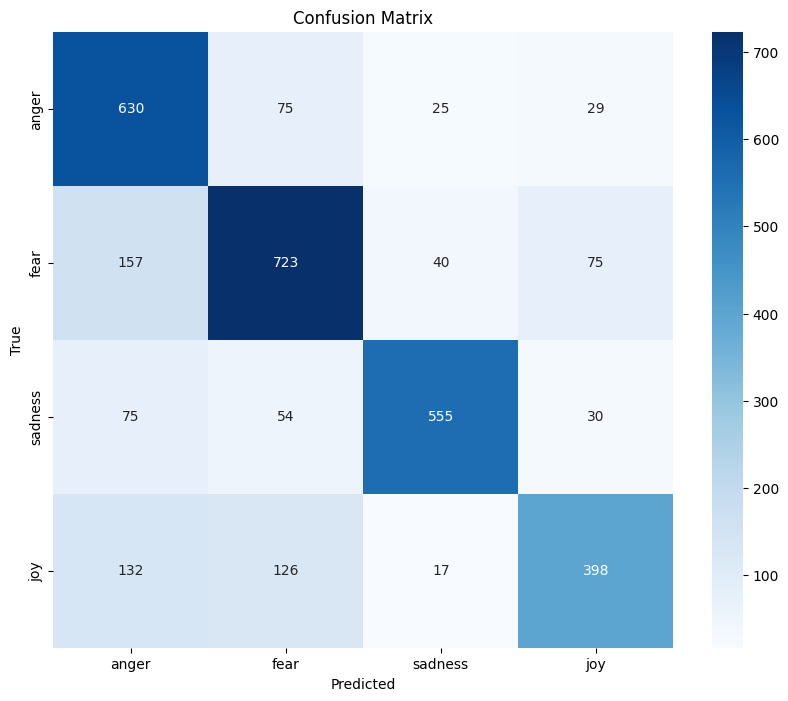

NameError: ignored

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments,EarlyStoppingCallback
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

#Load the pre-trained T5 model and tokenizer
model_name = "t5-small"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Prepare your dataset and convert it to a format suitable for training
# Ensure your dataset is in a format like:
# Function to load and preprocess the data
def load_dataset(file_path,tokenizer):
    tokenized_data = []

    with open(file_path, encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            # print(f"Line contents: {line}")  # Add this line to print the contents of each line
            parts = line.strip().split("\t")
            # print(f"parts[1]: {parts[1]}")
            if len(parts) >= 4:
              text, emotion  =  parts[1], parts[2]
              row = {'input_text':text,'target_text':emotion}
              input_text = row['input_text']
              target_text = row['target_text']
              input_ids = tokenizer.encode("classify the emotion: " + input_text, return_tensors="pt", padding="max_length", truncation=True, max_length=64)
              target_ids = tokenizer.encode(target_text, return_tensors="pt", padding="max_length", truncation=True, max_length=64)
              tokenized_data.append({
                  "input_ids": input_ids[0],
                  "attention_mask": (input_ids[0] != 0).long(),
                  "labels": target_ids[0],
              })



    return tokenized_data


train_dataset = load_dataset('home/train.txt',tokenizer)
test_dataset = load_dataset('home/test.txt',tokenizer)
validation_dataset = load_dataset('home/dev.txt',tokenizer)

print(f'test_dataset:{test_dataset}')

MAX_EPOCHS = 30

# Initialize the Trainer and TrainingArguments
training_args = TrainingArguments(
    output_dir="./t5",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=2,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    num_train_epochs=MAX_EPOCHS,
    load_best_model_at_end=True,
)
EARLY_STOPPING_PATIENCE = 3

# Add EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE, early_stopping_threshold=0.01)
callbacks = [early_stopping]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    callbacks=callbacks,
)


# Fine-tune the model
trainer.train()

# Extract training loss values
training_loss = trainer.state.log_history[-1]['train_loss']
print(f'trainer state:{trainer.state}')

EPOCHS_USED = trainer.state.epoch
print(f'EPOCHS_USED:{EPOCHS_USED}')



# Extract validation F1 score values
# validation_f1_values = trainer.state.log_history["train_loss"]
# print("Validation F1 Score Values:", validation_f1_values)


# Initialize lists to store predicted and true labels
predicted_train_labels = []
true_train_labels = []

# Generate predictions for the training dataset
# train_predictions = trainer.predict(train_dataset)

# Batch size for generating predictions
BATCH_SIZE = 32

# Generate predictions for the training dataset in smaller batches
for i in range(0, len(train_dataset), BATCH_SIZE):
    batch = train_dataset[i:i + BATCH_SIZE]
    predictions = trainer.predict(batch)
    predicted_train_labels.extend(predictions.predictions[0].argmax(axis=-1).tolist())
    true_train_labels.extend([item["labels"].tolist() for item in batch])


# Flatten the labels to 1D arrays
predicted_train_labels = [label for sublist in predicted_train_labels for label in sublist]
true_train_labels = [label for sublist in true_train_labels for label in sublist]

# Compute the F1 score
f1_train = f1_score(true_train_labels, predicted_train_labels, average='micro')
print(f'F1 Score on Training Data: {f1_train}')

#Save the model
trainer.save_model()
# Save the model, configuration, and tokenizer
model.save_pretrained("t5-classification-model")
tokenizer.save_pretrained("t5-classification-model")

# You can further evaluate the model on the test set and use it for inference.

model_predict = T5ForConditionalGeneration.from_pretrained('t5-classification-model')
tokenizer_predict = T5Tokenizer.from_pretrained('t5-classification-model',repo_type='model')

# Create a list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for item in test_dataset:
    input_ids = item["input_ids"].unsqueeze(0)
    attention_mask = item["attention_mask"].unsqueeze(0)

    # Generate predictions
    with torch.no_grad():
        output = model_predict.generate(input_ids, attention_mask=attention_mask, max_length=64)

    # Decode the predicted output
    predicted_text = tokenizer_predict.decode(output[0], skip_special_tokens=True)
    true_text = tokenizer_predict.decode(item["labels"], skip_special_tokens=True)

    true_labels.append(true_text)
    predicted_labels.append(predicted_text)

# Compute F1 score
f1_test = f1_score(true_labels, predicted_labels, average='micro')
print(f'F1 Score: {f1_test}')


# Create a confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion
labels = ['anger','fear','sadness','joy']
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

results_df['T5 Small Classification'] = [training_loss,'N/A',f1_train,f1_test,'N/A','N/A','N/A','N/A',EPOCHS_USED,'N/A','N/A',EARLY_STOPPING_PATIENCE,BATCH_SIZE]
results_df


# T5 Intensity Regression

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments,EarlyStoppingCallback
from sklearn.metrics import f1_score, confusion_matrix,r2_score,mean_squared_error as mse
import seaborn as sns
import matplotlib.pyplot as plt
import torch

#Load the pre-trained T5 model and tokenizer
model_name = "t5-classification-model"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Prepare your dataset and convert it to a format suitable for training
# Ensure your dataset is in a format like:
# Function to load and preprocess the data
def load_dataset(file_path,tokenizer):
    tokenized_data = []

    with open(file_path, encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 4:
              text, emotion,intensity  =  parts[1], parts[2],parts[3]
              row = {'input_text':text,'target_text':intensity  }
              input_text = row['input_text']
              target_text = row['target_text']
              input_ids = tokenizer.encode(f"Predict the Intensity for {emotion}: " + input_text, return_tensors="pt", padding="max_length", truncation=True, max_length=64)
              target_ids = tokenizer.encode(target_text, return_tensors="pt", padding="max_length", truncation=True, max_length=64)
              tokenized_data.append({
                  "input_ids": input_ids[0],
                  "attention_mask": (input_ids[0] != 0).long(),
                  "labels": target_ids[0],
              })



    return tokenized_data


train_dataset = load_dataset('home/train.txt',tokenizer)
test_dataset = load_dataset('home/test.txt',tokenizer)
validation_dataset = load_dataset('home/dev.txt',tokenizer)


MAX_EPOCHS = 30
EARLY_STOPPING_PATIENCE = 3
LEARNING_RATE = 2e-6

# Initialize the Trainer and TrainingArguments
training_args = TrainingArguments(
    output_dir="./t5-regression-model",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    save_total_limit=2,
    evaluation_strategy="steps",
    learning_rate=LEARNING_RATE,
    eval_steps=500,
    save_steps=500,
    num_train_epochs=MAX_EPOCHS,
    load_best_model_at_end=True,
)

# Add EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE, early_stopping_threshold=0.01)
callbacks = [early_stopping]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    callbacks=callbacks,
)


# Fine-tune the model
trainer.train()

# Extract training loss values
training_loss = trainer.state.log_history[-1]['train_loss']
print(f'trainer state:{trainer.state}')

EPOCHS_USED = trainer.state.epoch
print(f'EPOCHS_USED:{EPOCHS_USED}')



# Initialize lists to store predicted and true labels
predicted_train_outputs = []
true_train_outputs = []

# Generate predictions for the training dataset
# train_predictions = trainer.predict(train_dataset)

# # Batch size for generating predictions
BATCH_SIZE = 8

# Generate predictions for the training dataset in smaller batches
for i in range(0, len(train_dataset), BATCH_SIZE):
    batch = train_dataset[i:i + BATCH_SIZE]
    predictions = trainer.predict(batch)
    predicted_train_outputs.extend(predictions.predictions[0].argmax(axis=-1).tolist())
    true_train_outputs.extend([item["labels"].tolist() for item in batch])

print(f'predicted_train_outputs:{predicted_train_outputs}')
print(f'true_train_outputs:{true_train_outputs}')


# Flatten the labels to 1D arrays
predicted_train_outputs = [label for sublist in predicted_train_outputs for label in sublist]
true_train_outputs = [label for sublist in true_train_outputs for label in sublist]

# Compute the F1 score
r2_train = r2_score(true_train_outputs, predicted_train_outputs)
mse_train = mse(true_train_outputs, predicted_train_outputs)
print(f'true_train_labels:{true_train_outputs}')
print(f'predicted_train_labels:{predicted_train_outputs}')
print(f'R2 Score on Training Data: {r2_train}')
print(f'MSE Score on Training Data: {mse_train}')

#Save the model
trainer.save_model()
# Save the model, configuration, and tokenizer
model.save_pretrained("t5-regression-model")
tokenizer.save_pretrained("t5-regression-model")

# You can further evaluate the model on the test set and use it for inference.

model_predict = T5ForConditionalGeneration.from_pretrained('t5-regression-model')
tokenizer_predict = T5Tokenizer.from_pretrained('t5-regression-model',repo_type='model')

# Create a list to store true labels and predicted labels
true_test_outputs = []
predicted_test_outputs = []

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for item in test_dataset:
    input_ids = item["input_ids"].unsqueeze(0)
    attention_mask = item["attention_mask"].unsqueeze(0)

    # Generate predictions
    with torch.no_grad():
        output = model_predict.generate(input_ids, attention_mask=attention_mask, max_length=64)

    # Decode the predicted output
    predicted_test_intensity = tokenizer_predict.decode(output[0], skip_special_tokens=True)
    true_test_intensity = tokenizer_predict.decode(item["labels"], skip_special_tokens=True)

    true_test_outputs.append(float(true_test_intensity))
    predicted_test_outputs.append(0.0 if predicted_test_intensity == '' else float(predicted_test_intensity))

# Compute F1 score
r2_test = r2_score(true_test_outputs, predicted_test_outputs)
mse_test = mse(true_test_outputs,predicted_test_outputs)
print(f'predicted_test_outputs:{predicted_test_outputs}')
print(f'true_test_outputs:{true_test_outputs}')
print(f'R2 Score Test: {r2_test}')
print(f'MSE Score on Test Data: {mse_test}')


# Plot the confusion

results_df['T5 Small Regression'] = ['N/A',training_loss,'N/A','N/A','N/A',r2_train,r2_test,'N/A',EPOCHS_USED,'N/A',LEARNING_RATE,EARLY_STOPPING_PATIENCE,BATCH_SIZE]
results_df


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


trainer state:TrainerState(epoch=30.0, global_step=3390, max_steps=3390, logging_steps=500, eval_steps=500, save_steps=500, num_train_epochs=30, total_flos=1832697169182720.0, log_history=[{'loss': 0.4307, 'learning_rate': 1.7050147492625368e-06, 'epoch': 4.42, 'step': 500}, {'eval_loss': 0.2380741536617279, 'eval_runtime': 0.9237, 'eval_samples_per_second': 374.568, 'eval_steps_per_second': 11.908, 'epoch': 4.42, 'step': 500}, {'loss': 0.2345, 'learning_rate': 1.4100294985250735e-06, 'epoch': 8.85, 'step': 1000}, {'eval_loss': 0.16044673323631287, 'eval_runtime': 0.9228, 'eval_samples_per_second': 374.942, 'eval_steps_per_second': 11.92, 'epoch': 8.85, 'step': 1000}, {'loss': 0.1753, 'learning_rate': 1.1150442477876104e-06, 'epoch': 13.27, 'step': 1500}, {'eval_loss': 0.12780706584453583, 'eval_runtime': 0.9129, 'eval_samples_per_second': 379.008, 'eval_steps_per_second': 12.049, 'epoch': 13.27, 'step': 1500}, {'loss': 0.1481, 'learning_rate': 8.200589970501474e-07, 'epoch': 17.7, 'st

predicted_train_outputs:[[3, 22776, 4177, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4097, 22776, 4177, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 22776, 3747, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 22776, 4177, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 22776, 4177, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


predicted_test_outputs:[0.436, 0.447, 0.447, 0.409, 0.409, 0.438, 0.447, 0.447, 0.447, 0.1, 0.447, 0.447, 0.436, 0.447, 0.447, 0.447, 0.447, 0.447, 0.467, 0.447, 0.436, 0.447, 0.447, 0.486, 0.447, 0.447, 0.447, 0.486, 0.486, 0.447, 0.1, 0.447, 0.447, 0.438, 0.447, 0.467, 0.447, 0.436, 0.446, 0.446, 0.447, 0.447, 0.467, 0.447, 0.447, 0.467, 0.447, 0.447, 0.447, 0.436, 0.447, 0.447, 0.447, 0.436, 0.447, 0.446, 0.447, 0.447, 0.436, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.447, 0.438, 0.447, 0.467, 0.1, 0.447, 0.1, 0.486, 0.446, 0.447, 0.436, 0.447, 0.1, 0.467, 0.467, 0.447, 0.447, 0.447, 0.447, 0.447, 0.467, 0.447, 0.447, 0.447, 0.447, 0.436, 0.447, 0.447, 0.447, 0.447, 0.447, 0.468, 0.439, 0.447, 0.447, 0.83, 0.447, 0.6, 0.436, 0.436, 0.436, 0.447, 0.447, 0.436, 0.447, 0.447, 0.667, 0.447, 0.447, 0.436, 0.447, 0.467, 0.447, 0.447, 0.1, 0.447, 0.447, 0.447, 0.447, 0.447, 0.6, 0.447, 0.447, 0.446, 0.447, 0.436, 0.447, 0.447, 0.447, 0.467, 0.447, 0.447, 0.447, 0.447, 0.1, 0.438, 0

Metric T5 Small Regression
0   Classifcation Loss                 N/A
1      Regression Loss            0.200353
2          Training F1                 N/A
3              Test F1                 N/A
4        Validation F1                 N/A
5          Training R2            0.767332
6              Test R2           -0.326197
7        Validation R2                 N/A
8            Max Epoch                30.0
9           Optimzizer                 N/A
10       Learning Rate            0.000002
11            Patience                   3
12          Batch Size                   8

#T5 Multimodal Classification + Regression

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments,EarlyStoppingCallback
from sklearn.metrics import f1_score, confusion_matrix,r2_score,mean_squared_error as mse
import seaborn as sns
import matplotlib.pyplot as plt
import torch

#Load the pre-trained T5 model and tokenizer
model_name = "t5-small"
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Prepare your dataset and convert it to a format suitable for training
# Ensure your dataset is in a format like:
# Function to load and preprocess the data
def load_dataset(file_path,tokenizer):
    tokenized_data = []

    with open(file_path, encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 4:
              text, emotion,intensity  =  parts[1], parts[2],parts[3]
              row = {'input_text':text,'target_text':emotion +" - " +intensity } #Emotion and Intensity
              input_text = row['input_text']
              target_text = row['target_text']
              input_ids = tokenizer.encode(f"Predict the Emotion and it's Intensity: " + input_text +'.', return_tensors="pt", padding="max_length", truncation=True, max_length=64)
              target_ids = tokenizer.encode(target_text, return_tensors="pt", padding="max_length", truncation=True, max_length=64)
              tokenized_data.append({
                  "input_ids": input_ids[0],
                  "attention_mask": (input_ids[0] != 0).long(),
                  "labels": target_ids[0],
              })



    return tokenized_data


train_dataset = load_dataset('home/train.txt',tokenizer)
test_dataset = load_dataset('home/test.txt',tokenizer)
validation_dataset = load_dataset('home/dev.txt',tokenizer)

BATCH_SIZE=32
MAX_EPOCHS = 30
EARLY_STOPPING_PATIENCE = 3
LEARNING_RATE = 2e-6

# Initialize the Trainer and TrainingArguments
training_args = TrainingArguments(
    output_dir="./t5-multitask-model",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    save_total_limit=2,
    evaluation_strategy="steps",
    learning_rate=LEARNING_RATE,
    eval_steps=500,
    save_steps=500,
    num_train_epochs=MAX_EPOCHS,
    load_best_model_at_end=True,
)

# Add EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE, early_stopping_threshold=0.01)
callbacks = [early_stopping]

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    callbacks=callbacks,
)


# Fine-tune the model
trainer.train()

# Extract training loss values
training_loss = trainer.state.log_history[-1]['train_loss']
print(f'trainer state:{trainer.state}')

EPOCHS_USED = trainer.state.epoch
print(f'EPOCHS_USED:{EPOCHS_USED}')



# Initialize lists to store predicted and true labels
predicted_train_outputs = []
true_train_outputs = []

# Generate predictions for the training dataset
# train_predictions = trainer.predict(train_dataset)


# Generate predictions for the training dataset in smaller batches
for i in range(0, len(train_dataset), BATCH_SIZE):
    batch = train_dataset[i:i + BATCH_SIZE]
    predictions = trainer.predict(batch)
    predicted_train_outputs.extend(predictions.predictions[0].argmax(axis=-1).tolist())
    true_train_outputs.extend([item["labels"].tolist() for item in batch])

print(f'predicted_train_outputs:{predicted_train_outputs}')
print(f'true_train_outputs:{true_train_outputs}')


# # Flatten the labels to 1D arrays
# predicted_train_outputs = [label for sublist in predicted_train_outputs for label in sublist]
# true_train_outputs = [label for sublist in true_train_outputs for label in sublist]

# # Compute the F1 score
# r2_train = r2_score(true_train_outputs, predicted_train_outputs)
# mse_train = mse(true_train_outputs, predicted_train_outputs)
# print(f'true_train_labels:{true_train_outputs}')
# print(f'predicted_train_labels:{predicted_train_outputs}')
# print(f'R2 Score on Training Data: {r2_train}')
# print(f'MSE Score on Training Data: {mse_train}')

# #Save the model
# trainer.save_model()
# # Save the model, configuration, and tokenizer
# model.save_pretrained("t5-multitask-model")
# tokenizer.save_pretrained("t5-multitask-model")

# # You can further evaluate the model on the test set and use it for inference.

# model_predict = T5ForConditionalGeneration.from_pretrained('t5-multitask-model')
# tokenizer_predict = T5Tokenizer.from_pretrained('t5-multitask-model',repo_type='model')

# # Create a list to store true labels and predicted labels
# true_test_outputs = []
# predicted_test_outputs = []

# # Set up the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# for item in test_dataset:
#     input_ids = item["input_ids"].unsqueeze(0)
#     attention_mask = item["attention_mask"].unsqueeze(0)

#     # Generate predictions
#     with torch.no_grad():
#         output = model_predict.generate(input_ids, attention_mask=attention_mask, max_length=64)

#     # Decode the predicted output
#     predicted_test_intensity = tokenizer_predict.decode(output[0], skip_special_tokens=True)
#     true_test_intensity = tokenizer_predict.decode(item["labels"], skip_special_tokens=True)

#     true_test_outputs.append(float(true_test_intensity))
#     predicted_test_outputs.append(0.0 if predicted_test_intensity == '' else float(predicted_test_intensity))

# # Compute F1 score
# r2_test = r2_score(true_test_outputs, predicted_test_outputs)
# mse_test = mse(true_test_outputs,predicted_test_outputs)
# print(f'predicted_test_outputs:{predicted_test_outputs}')
# print(f'true_test_outputs:{true_test_outputs}')
# print(f'R2 Score Test: {r2_test}')
# print(f'MSE Score on Test Data: {mse_test}')


# # Plot the confusion

# results_df['T5 Multi-task Modal (Class+Reg)'] = ['N/A',training_loss,'N/A','N/A','N/A',r2_train,r2_test,'N/A',EPOCHS_USED,'N/A',LEARNING_RATE,EARLY_STOPPING_PATIENCE,BATCH_SIZE]
# results_df


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


trainer state:TrainerState(epoch=30.0, global_step=3390, max_steps=3390, logging_steps=500, eval_steps=500, save_steps=500, num_train_epochs=30, total_flos=1832697169182720.0, log_history=[{'loss': 10.127, 'learning_rate': 1.7050147492625368e-06, 'epoch': 4.42, 'step': 500}, {'eval_loss': 1.698645830154419, 'eval_runtime': 0.902, 'eval_samples_per_second': 383.591, 'eval_steps_per_second': 12.195, 'epoch': 4.42, 'step': 500}, {'loss': 2.0898, 'learning_rate': 1.4100294985250735e-06, 'epoch': 8.85, 'step': 1000}, {'eval_loss': 0.6873185038566589, 'eval_runtime': 0.9417, 'eval_samples_per_second': 367.419, 'eval_steps_per_second': 11.681, 'epoch': 8.85, 'step': 1000}, {'loss': 1.033, 'learning_rate': 1.1150442477876104e-06, 'epoch': 13.27, 'step': 1500}, {'eval_loss': 0.6169424057006836, 'eval_runtime': 0.9053, 'eval_samples_per_second': 382.188, 'eval_steps_per_second': 12.15, 'epoch': 13.27, 'step': 1500}, {'loss': 0.693, 'learning_rate': 8.200589970501474e-07, 'epoch': 17.7, 'step': 2

predicted_train_outputs:[[0, 3, 18, 3, 19997, 4448, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3, 18, 3, 19997, 4448, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3, 18, 3, 19997, 4448, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3, 18, 3, 19997, 4448, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3, 18, 3, 19997, 4448, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Classification Distil Roberta

In [ ]:
## Distil Roberta Classification

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score,f1_score,confusion_matrix



# Load pre-trained BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
multi_task_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')




# Define the Multi-Task Emotion Model
class SingleTaskEmotionModel(torch.nn.Module):
    def __init__(self, bert_model, num_classes):
        super(SingleTaskEmotionModel, self).__init__()
        self.bert = bert_model
        self.classification_head = torch.nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None):
        # print(f"input_ids: {input_ids}")
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,output_hidden_states=True)

        # Extract last hidden state
        pooled_output = outputs.hidden_states[-1][:, 0, :]

        # For classification task
        classification_logits = self.classification_head(pooled_output)

        return classification_logits

# Function to load and preprocess the data
def load_data(file_path, tokenizer):
    texts = []
    labels_classification = []

    with open(file_path, encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 4:
              text, emotion, intensity =  parts[1], parts[2], float(parts[3])
              texts.append(text)
              labels_classification.append(emotion)


    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Use label encoding for emotion labels
    emotion_label_encoder = LabelEncoder()
    labels_classification_encoded = emotion_label_encoder.fit_transform(labels_classification)

    labels_classification = torch.tensor(labels_classification_encoded)


    return TensorDataset(inputs.input_ids, inputs.attention_mask, labels_classification)

# # Load the data
train_dataset = load_data('home/train.txt', tokenizer)
valid_dataset = load_data('home/dev.txt', tokenizer)
test_dataset = load_data('home/test.txt', tokenizer)

# Create DataLoader objects
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the multi-task model
NUM_CLASSES = 4  # Number of emotion categories (anger, fear, joy, sadness)
single_task_model = SingleTaskEmotionModel(classification_model, num_classes=NUM_CLASSES)
single_task_model.to(device)

# Hyperparameters
LEARNING_RATE = 2e-5
OPTIMIZER = 'AdamW'
# Set up the optimizer and loss functions
optimizer = AdamW(multi_task_model.parameters(), lr=LEARNING_RATE)
classification_criterion = torch.nn.CrossEntropyLoss()

# Train the single-task model
NUM_EPOCHS = 30
# Early stopping parameters
early_stopping_patience = 6  # Number of epochs to wait for improvement
best_combined_loss = float('inf')  # Initialize the best validation loss
no_improvement_count = 0  # Initialize the count for the number of epochs with no improvement
for epoch in range(NUM_EPOCHS):
    single_task_model.train()
    total_classification_loss = 0.0
    total_regression_loss = 0.0
    all_predicted_train_labels = []
    all_true_train_labels = []

    for batch in train_loader:
        batch_input_ids, batch_attention_mask, batch_labels_classification = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device)

        optimizer.zero_grad()
        classification_logits = single_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_loss = classification_criterion(classification_logits, batch_labels_classification)


        classification_loss.backward()
        optimizer.step()

        total_classification_loss += classification_loss.item()

        ## Classification Accuracy variables
        predicted_labels = classification_logits.argmax(dim=1)
        all_predicted_train_labels.extend(predicted_labels.cpu().numpy())
        all_true_train_labels.extend(batch_labels_classification.cpu().numpy())

     ## Validation

    for batch in valid_loader:
        single_task_model.eval()
        batch_input_ids, batch_attention_mask, batch_labels_classification = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device)

        optimizer.zero_grad()
        classification_logits = single_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_val_loss = classification_criterion(classification_logits, batch_labels_classification)


        total_val_classification_loss += classification_loss.item()


    average_combined_val_loss = classification_val_loss/len(valid_loader)
    print(f'average_combined_val_loss:{average_combined_val_loss}')
    # Check for early stopping
    if average_combined_val_loss < best_combined_loss:
        best_combined_loss = average_combined_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # If there's no improvement for the specified patience, stop training
    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
        break


    ## Calculate Classification Accuracy
    classification_accuracy = f1_score(all_true_train_labels, all_predicted_train_labels,average='weighted')

    ## Training confusion Metrics
    # Calculate the confusion matrix
    # confusion = confusion_matrix(all_true_labels, all_predicted_labels)

    # # Extract values from the confusion matrix
    # tn, fp, fn, tp = confusion.ravel()

    # # Print false positives and false negatives
    # print(f'False Positives (FP): {fp}')
    # print(f'False Negatives (FN): {fn}')

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, '
          f'Classification Loss: {total_classification_loss / len(train_loader):.3f}')
    print(f'Clasification Training F1 Score: {classification_accuracy}')

# Function for evaluation
def evaluate_model(model, data_loader, classification_criterion):
    model.eval()
    total_classification_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []


    with torch.no_grad():
        for batch in data_loader:
            batch_input_ids, batch_attention_mask, batch_labels_classification = batch
            batch_input_ids, batch_attention_mask, batch_labels_classification = \
                batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device)


            classification_logits = model(batch_input_ids, attention_mask=batch_attention_mask)


            ## Classification Accuracy
            predicted_labels = classification_logits.argmax(dim=1)

            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels.extend(batch_labels_classification.cpu().numpy())


            classification_loss = classification_criterion(classification_logits, batch_labels_classification)
            total_classification_loss += classification_loss.item()

    #Classification Accuracy
    classification_accuracy = f1_score(all_true_labels, all_predicted_labels,average='weighted')

    avg_classification_loss = total_classification_loss / len(data_loader)

    return avg_classification_loss, classification_accuracy

# # Evaluate the model on the validation set
valid_classification_loss, valid_classification_accuracy = evaluate_model(single_task_model, valid_loader,
                                                                   classification_criterion)
print(f'Validation Classification Loss: {valid_classification_loss:.3f}')
print(f'Validation Classification Accuracy: {valid_classification_accuracy:.3f}')



# Evaluate the model on the test set
test_classification_loss,test_classification_accuracy = evaluate_model(single_task_model, test_loader,
                                                                 classification_criterion)



print(f'Test Classification Loss: {test_classification_loss:.3f}')
print(f'Test Classification Accuracy: {test_classification_accuracy:.3f}')


#Save this Model
#torch.save(multi_task_model.state_dict(), 'my_custom_EmoRoBERTa_multi_model.pth')


results_df['Distil_BERT_Classification'] = [total_classification_loss / len(train_loader),'N/A',classification_accuracy,test_classification_accuracy,valid_classification_accuracy,'N/A','N/A','N/A',epoch,OPTIMIZER,LEARNING_RATE,early_stopping_patience,BATCH_SIZE]
results_df



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


average_combined_val_loss:0.13980162143707275
Epoch 1/30, Classification Loss: 1.398
Clasification Training F1 Score: 0.26931775010648873
average_combined_val_loss:0.13980162143707275
Epoch 2/30, Classification Loss: 1.399
Clasification Training F1 Score: 0.28472985779998944
average_combined_val_loss:0.13980162143707275
Epoch 3/30, Classification Loss: 1.399
Clasification Training F1 Score: 0.27661781573905125
average_combined_val_loss:0.13980162143707275
Epoch 4/30, Classification Loss: 1.399
Clasification Training F1 Score: 0.2690645533592296
average_combined_val_loss:0.13980162143707275
Epoch 5/30, Classification Loss: 1.394
Clasification Training F1 Score: 0.27536818501555405
average_combined_val_loss:0.13980162143707275
Epoch 6/30, Classification Loss: 1.393
Clasification Training F1 Score: 0.28325203264450133
average_combined_val_loss:0.13980162143707275
Early stopping triggered after 7 epochs without improvement.
Validation Classification Loss: 1.433
Validation Classification Ac

Metric MultiModal Roberta_MultiModal Roberta_Classification  \
0   Classifcation Loss   0.037827           0.053516               0.066044   
1      Regression Loss   0.094097           0.022945                    N/A   
2          Training F1   0.979524           0.974795                0.97315   
3              Test F1   0.847819           0.859917               0.854546   
4        Validation F1   0.869942           0.861272               0.843822   
5          Training R2   0.608306           0.339113                    N/A   
6              Test R2   0.399914           0.305318                    N/A   
7        Validation R2   0.285307           0.083729                    N/A   
8            Max Epoch         11                 13                      3   
9           Optimzizer      AdamW              AdamW                  AdamW   
10       Learning Rate    0.00002            0.00001                0.00002   
11            Patience          3                  3                      3   
12          Batch Size         32                 32                     32   

   Bert_Classification T5 Small Classification Distil_BERT_Classification  
0             0.166192                0.187728                   1.394824  
1                  N/A                     N/A                        N/A  
2             0.934657                0.996621                   0.283252  
3              0.72267                0.734161                   0.251019  
4             0.728016                     N/A                    0.30927  
5                  N/A                     N/A                        N/A  
6                  N/A                     N/A                        N/A  
7                  N/A                     N/A                        N/A  
8                    9                      30                          6  
9                AdamW                     N/A                      AdamW  
10             0.00002                     N/A                    0.00002  
11                   3                       3                          6  
12                  32                      32                         32

# Multitask Distil BERT

In [ ]:
## Distil BERT multitask

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score,f1_score,confusion_matrix



# Load pre-trained BERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
multi_task_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')



# Define the Multi-Task Emotion Model
class MultiTaskEmotionModel(torch.nn.Module):
    def __init__(self, bert_model, num_classes):
        super(MultiTaskEmotionModel, self).__init__()
        self.bert = bert_model
        self.classification_head = torch.nn.Linear(self.bert.config.hidden_size, num_classes)
        self.regression_head = torch.nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        # print(f"input_ids: {input_ids}")
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,output_hidden_states=True)

        # Extract last hidden state
        pooled_output = outputs.hidden_states[-1][:, 0, :]

        # For classification task
        classification_logits = self.classification_head(pooled_output)


        # For regression task
        regression_output = self.regression_head(pooled_output)



        return classification_logits, regression_output

# Function to load and preprocess the data
def load_data(file_path, tokenizer):
    texts = []
    labels_classification = []
    labels_regression = []

    with open(file_path, encoding='utf-8') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 4:
              text, emotion, intensity =  parts[1], parts[2], float(parts[3])
              texts.append(text)
              labels_classification.append(emotion)
              labels_regression.append(intensity)


    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Use label encoding for emotion labels
    emotion_label_encoder = LabelEncoder()
    labels_classification_encoded = emotion_label_encoder.fit_transform(labels_classification)

    labels_classification = torch.tensor(labels_classification_encoded)

    labels_regression = torch.tensor(labels_regression,dtype=torch.float)


    return TensorDataset(inputs.input_ids, inputs.attention_mask, labels_classification, labels_regression)

# # Load the data
train_dataset = load_data('home/train.txt', tokenizer)
valid_dataset = load_data('home/dev.txt', tokenizer)
test_dataset = load_data('home/test.txt', tokenizer)

# Create DataLoader objects
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the multi-task model
NUM_CLASSES = 4  # Number of emotion categories (anger, fear, joy, sadness)
multi_task_model = MultiTaskEmotionModel(classification_model, num_classes=NUM_CLASSES)
multi_task_model.to(device)

LEARNING_RATE = 1e-5
OPTIMZER = 'AdamW'
# Set up the optimizer and loss functions
optimizer = AdamW(multi_task_model.parameters(), lr=LEARNING_RATE)
classification_criterion = torch.nn.CrossEntropyLoss()
regression_criterion = torch.nn.MSELoss()

# Train the multi-task model
NUM_EPOCHS = 30
# Early stopping parameters
early_stopping_patience = 3  # Number of epochs to wait for improvement
best_combined_loss = float('inf')  # Initialize the best validation loss
no_improvement_count = 0  # Initialize the count for the number of epochs with no improvement
for epoch in range(NUM_EPOCHS):
    multi_task_model.train()
    total_classification_loss = 0.0
    total_regression_loss = 0.0
    total_val_classification_loss = 0.0
    total_val_regression_loss = 0.0
    combined_val_total_loss =0.0
    #train
    all_predicted_train_labels = []
    all_true_train_labels = []
    all_predicted_train_outputs = []
    all_true_train_outputs = []



    for batch in train_loader:
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device), batch_labels_regression.to(device)

        optimizer.zero_grad()
        classification_logits, regression_output = multi_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_loss = classification_criterion(classification_logits, batch_labels_classification)
        regression_loss = regression_criterion(regression_output.squeeze(), batch_labels_regression)


        # Total loss is a weighted combination of classification and regression losses
        total_loss = classification_loss + regression_loss

        total_loss.backward()
        optimizer.step()

        total_classification_loss += classification_loss.item()
        total_regression_loss += regression_loss.item()

        ## Classification Accuracy variables
        predicted_labels = classification_logits.argmax(dim=1)
        all_predicted_train_labels.extend(predicted_labels.cpu().numpy())
        all_true_train_labels.extend(batch_labels_classification.cpu().numpy())


        # Regression Training Accuracy outputs

        predicted_outputs = regression_output.flatten()
        true_outputs = batch_labels_regression

        all_predicted_train_outputs.extend(predicted_outputs)
        all_true_train_outputs.extend(true_outputs)

    ## Validation

    for batch in valid_loader:
        multi_task_model.eval()
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = batch
        batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = \
            batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device), batch_labels_regression.to(device)

        optimizer.zero_grad()
        classification_logits, regression_output = multi_task_model(batch_input_ids, attention_mask=batch_attention_mask)

        # Compute losses for classification and regression tasks
        classification_val_loss = classification_criterion(classification_logits, batch_labels_classification)
        # regression_loss = regression_criterion(regression_output, labels_regression)


        regression_val_loss = regression_criterion(regression_output.squeeze(), batch_labels_regression)
        # regression_loss = regression_criterion(regression_output_rounded, batch_labels_regression.cpu())


        # Total loss is a weighted combination of classification and regression losses
        combined_val_loss = classification_val_loss + regression_val_loss

        total_val_classification_loss += classification_loss.item()
        total_val_regression_loss += regression_loss.item()
        combined_val_total_loss = total_val_classification_loss + total_val_regression_loss





    average_combined_val_loss = combined_val_total_loss/len(valid_loader)
    print(f'average_combined_val_loss:{average_combined_val_loss}')
    # Check for early stopping
    if average_combined_val_loss < best_combined_loss:
        best_combined_loss = average_combined_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # If there's no improvement for the specified patience, stop training
    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
        break



    ## Calculate Classification Accuracy
    classification_accuracy = f1_score(all_true_train_labels, all_predicted_train_labels,average='weighted')

    ## Calculate Regression Accuracy using R2
    regression_train_accuracy = r2_score([item.detach().cpu().numpy() for item in all_true_train_outputs], [item.detach().cpu().numpy() for item in all_predicted_train_outputs])

    ## Training confusion Metrics
    # Calculate the confusion matrix
    # confusion = confusion_matrix(all_true_labels, all_predicted_labels)

    # # Extract values from the confusion matrix
    # tn, fp, fn, tp = confusion.ravel()

    # # Print false positives and false negatives
    # print(f'False Positives (FP): {fp}')
    # print(f'False Negatives (FN): {fn}')

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, '
          f'Classification Loss: {total_classification_loss / len(train_loader):.3f}, '
          f'Regression Loss: {total_regression_loss / len(train_loader):.3f}')

    print(f'Clasification Training F1 Score: {classification_accuracy}')
    # print(f'Regression Training R2 Score {regression_accuracy}')

# Function for evaluation
def evaluate_model(model, data_loader, classification_criterion, regression_criterion):
    model.eval()
    total_classification_loss = 0.0
    total_regression_loss = 0.0
    all_predicted_labels = []
    all_true_labels = []
    all_predicted_outputs = []
    all_true_outputs = []

    with torch.no_grad():
        for batch in data_loader:
            batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = batch
            batch_input_ids, batch_attention_mask, batch_labels_classification, batch_labels_regression = \
                batch_input_ids.to(device), batch_attention_mask.to(device), batch_labels_classification.to(device), batch_labels_regression.to(device)


            classification_logits, regression_output = model(batch_input_ids, attention_mask=batch_attention_mask)


            ## Classification Accuracy
            predicted_labels = classification_logits.argmax(dim=1)

            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels.extend(batch_labels_classification.cpu().numpy())

            ## Regression Accuracy Variables
            predicted_outputs = regression_output.flatten().cpu()


            true_outputs = batch_labels_regression.cpu()

            all_predicted_outputs.extend(predicted_outputs)
            all_true_outputs.extend(true_outputs)



            classification_loss = classification_criterion(classification_logits, batch_labels_classification)
            regression_loss = regression_criterion(regression_output.squeeze(),batch_labels_regression)



            total_classification_loss += classification_loss.item()
            total_regression_loss += regression_loss.item()

    #Classification Accuracy
    classification_accuracy = accuracy_score(all_true_labels, all_predicted_labels)


    ## Regression Accuracy
    # regression_accuracy = mean_squared_error(all_true_outputs, all_predicted_outputs)

    # Calculate the R-squared (R2) score
    regression_accuracy = r2_score(all_true_outputs, all_predicted_outputs)




    avg_classification_loss = total_classification_loss / len(data_loader)
    avg_regression_loss = total_regression_loss / len(data_loader)

    return avg_classification_loss, avg_regression_loss, classification_accuracy,regression_accuracy

# # Evaluate the model on the validation set
valid_classification_loss, valid_regression_loss, valid_classification_accuracy, valid_regression_accuracy = evaluate_model(multi_task_model, valid_loader,
                                                                   classification_criterion, regression_criterion)
print(f'Validation Classification Loss: {valid_classification_loss:.3f}, '
      f'Validation Regression Loss: {valid_regression_loss:.3f}')
print(f'Validation Classification Accuracy: {valid_classification_accuracy:.3f}')
print(f'Validation Regression Accuracy: {valid_regression_accuracy:.3f}')



# Evaluate the model on the test set
test_classification_loss, test_regression_loss,test_classification_accuracy,test_regression_accuracy = evaluate_model(multi_task_model, test_loader,
                                                                 classification_criterion, regression_criterion)



print(f'Test Classification Loss: {test_classification_loss:.3f}, '
      f'Test Regression Loss: {test_regression_loss:.3f}')
print(f'Test Regression Accuracy: {test_regression_accuracy:.3f}')
print(f'Test Classification Accuracy: {test_classification_accuracy:.3f}')


#Save this Model
#torch.save(multi_task_model.state_dict(), 'my_custom_EmoRoBERTa_multi_model.pth')

results_df['Distil_BERT_MultiTaskModal'] = [total_classification_loss / len(train_loader),total_regression_loss / len(train_loader),classification_accuracy,test_classification_accuracy,valid_classification_accuracy,regression_train_accuracy,test_regression_accuracy,valid_regression_accuracy,epoch,OPTIMIZER,LEARNING_RATE,early_stopping_patience,BATCH_SIZE]
results_df



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


average_combined_val_loss:0.18699996918439865
Epoch 1/30, Classification Loss: 0.301, Regression Loss: 0.083
Clasification Training F1 Score: 0.9157017640448389
average_combined_val_loss:0.07211354933679104
Epoch 2/30, Classification Loss: 0.115, Regression Loss: 0.055
Clasification Training F1 Score: 0.9620721655461458
average_combined_val_loss:0.09027742594480515
Epoch 3/30, Classification Loss: 0.079, Regression Loss: 0.049
Clasification Training F1 Score: 0.9712137401542716
average_combined_val_loss:0.057129593566060066
Epoch 4/30, Classification Loss: 0.083, Regression Loss: 0.048
Clasification Training F1 Score: 0.9703978966826856
average_combined_val_loss:0.14466571062803268
Epoch 5/30, Classification Loss: 0.068, Regression Loss: 0.043
Clasification Training F1 Score: 0.9753203237905614
average_combined_val_loss:0.047700442373752594
Epoch 6/30, Classification Loss: 0.069, Regression Loss: 0.044
Clasification Training F1 Score: 0.972876026706294
average_combined_val_loss:0.13904

Metric MultiModal Roberta_MultiModal Roberta_Classification  \
0   Classifcation Loss   0.037827           0.053516               0.066044   
1      Regression Loss   0.094097           0.022945                    N/A   
2          Training F1   0.979524           0.974795                0.97315   
3              Test F1   0.847819           0.859917               0.854546   
4        Validation F1   0.869942           0.861272               0.843822   
5          Training R2   0.608306           0.339113                    N/A   
6              Test R2   0.399914           0.305318                    N/A   
7        Validation R2   0.285307           0.083729                    N/A   
8            Max Epoch         11                 13                      3   
9           Optimzizer      AdamW              AdamW                  AdamW   
10       Learning Rate    0.00002            0.00001                0.00002   
11            Patience          3                  3                      3   
12          Batch Size         32                 32                     32   

   Bert_Classification T5 Small Classification Distil_BERT_Classification  \
0             0.166192                0.187728                   1.394824   
1                  N/A                     N/A                        N/A   
2             0.934657                0.996621                   0.283252   
3              0.72267                0.734161                   0.251019   
4             0.728016                     N/A                    0.30927   
5                  N/A                     N/A                        N/A   
6                  N/A                     N/A                        N/A   
7                  N/A                     N/A                        N/A   
8                    9                      30                          6   
9                AdamW                     N/A                      AdamW   
10             0.00002                     N/A                    0.00002   
11                   3                       3                          6   
12                  32                      32                         32   

   Distil_BERT_MultiTaskModal  
0                    0.049903  
1                    0.032433  
2                    0.979798  
3                    0.736708  
4                    0.739884  
5                     0.04968  
6                    0.071617  
7                    0.036596  
8                          12  
9                       AdamW  
10                    0.00001  
11                          3  
12                         32